## Goal:

We are going to be bringing in the data from the website 247 sports. This website has the national rankings, position ranking, state ranking, and 247 ranking score for each player who commited to a NCAA DI college out of high school. 


In [1]:
! pip install lxml
! pip install html5lib
from urllib.request import urlopen
from bs4 import BeautifulSoup
from bs4 import SoupStrainer
import pandas as pd
import requests
import re
import getpass
import psycopg2
from psycopg2.extensions import adapt, register_adapter, AsIs
import sys
import string
import unicodedata
import seaborn as sns
pd.set_option('display.max_columns', 500)

     |████████████████████████████████| 5.7MB 1.6MB/s eta 0:00:01
     |████████████████████████████████| 122kB 1.8MB/s eta 0:00:01


The first step is to get all of the college names that are in the 247 sports database. To do this we look at their webpage that lists links to all college pages. 

We use beautifulsoup package in python to get the html of the page. The first step is to use the find all command to get a list of all the conference tables. 

Next we loop through the conference tables to get the weblink accosiated with the colleges.

Once we have the web link we use regex to cut out the college name in the weblink. Add the college name to the college name list that we will loop through in the next step.



In [2]:
college_list = []
HEADERS = {'User-Agent': 'request', 'X-Requested-With': 'XMLHttpRequest'}
r = requests.get('https://247sports.com/league/NCAA-BK/Teams/', headers=HEADERS)
soup = BeautifulSoup(r.text, 'html.parser')
tag = soup.findAll('ul',{'class':"division-team_lst"})
for tags in tag:
    text = tags.findAll('a',{'class':'roster-link'})
    for link in text:
        college = link.get('href')
        name = re.search('(?<=college/)([^/]*)',college)
        
        if name:
            college_list.append(name.group(0))


    

Let's view the college names that are in the list

In [3]:
college_list

['boston-college',
 'clemson',
 'duke',
 'florida-state',
 'georgia-tech',
 'louisville',
 'miami',
 'north-carolina-state',
 'north-carolina',
 'notre-dame',
 'pittsburgh',
 'syracuse',
 'virginia',
 'virginia-tech',
 'wake-forest',
 'baylor',
 'iowa-state',
 'kansas',
 'kansas-state',
 'oklahoma',
 'oklahoma-state',
 'tcu',
 'texas',
 'texas-tech',
 'west-virginia',
 'illinois',
 'indiana',
 'iowa',
 'maryland',
 'michigan-state',
 'michigan',
 'minnesota',
 'nebraska',
 'northwestern',
 'ohio-state',
 'penn-state',
 'purdue',
 'rutgers',
 'wisconsin',
 'arizona-state',
 'arizona',
 'california',
 'colorado',
 'oregon',
 'oregon-state',
 'stanford',
 'ucla',
 'usc',
 'utah',
 'washington',
 'washington-state',
 'alabama',
 'arkansas',
 'auburn',
 'florida',
 'georgia',
 'kentucky',
 'lsu',
 'mississippi-state',
 'missouri',
 'ole-miss',
 'south-carolina',
 'tennessee',
 'texas-am',
 'vanderbilt',
 'albany',
 'binghamton',
 'hartford',
 'maine',
 'new-hampshire',
 'stony-brook',
 'umb

Now we need to gather the data from the website. We start by declaring what the year range we want to loop through. 
The website starts recruiting data at 2003, so that is when we start. 

The first loop is the years that we loop through. The second loop is through the college list we previously created. 

For each year and team we get the table of the players who commit to that college that year. We next loop through that table to get each row which represents each player. Next we loop through each row for each column of that players info. We put all this info into a row and append that row into the dataframe.

In [4]:
START   = 2003
END     = 2021
HEADERS = {'User-Agent': 'request', 'X-Requested-With': 'XMLHttpRequest'}


data = pd.DataFrame(columns = ['name','high_school','position','ht_wt','national_rank','position_rank','state_rank','recruit_score','college','year'])
row = []
for year in range(START, END):
    for team in college_list:
        print('Getting %s page %s' % (year, team))
        print('https://247sports.com/college/{}/Season/{}-Basketball/Commits/'.format(team,year))
        r = requests.get('https://247sports.com/college/{}/Season/{}-Basketball/Commits/'.format(team,year), headers=HEADERS)
        soup = BeautifulSoup(r.text, 'html.parser')
        table = soup.findAll('li',{'class':'ri-page__list-item'})
        for player in table:
            recruit = player.findAll('div', {'class':'wrapper'})
            for info in recruit:
                name = info.find('a',{'class':"ri-page__name-link"}).text
                hs = info.find('span',{'class':'meta'}).text
                pos = info.find('div',{'class':'position'}).text
                metrics = info.find('div',{'class':'metrics'}).text
                nat_rank = info.find('a',{'class':'natrank'}).text
                pos_rank = info.find('a',{'class','posrank'}).text
                st_rank = info.find('a',{'class':'sttrank'}).text
                score = info.find('span',{'class':'score'}).text
                row = [name,hs,pos,metrics,nat_rank,pos_rank,st_rank,score,team,year]
                data.loc[len(data)] = row
print('Fetched ranking data successfully')

Getting 2003 page boston-college
https://247sports.com/college/boston-college/Season/2003-Basketball/Commits/
Getting 2003 page clemson
https://247sports.com/college/clemson/Season/2003-Basketball/Commits/
Getting 2003 page duke
https://247sports.com/college/duke/Season/2003-Basketball/Commits/
Getting 2003 page florida-state
https://247sports.com/college/florida-state/Season/2003-Basketball/Commits/
Getting 2003 page georgia-tech
https://247sports.com/college/georgia-tech/Season/2003-Basketball/Commits/
Getting 2003 page louisville
https://247sports.com/college/louisville/Season/2003-Basketball/Commits/
Getting 2003 page miami
https://247sports.com/college/miami/Season/2003-Basketball/Commits/
Getting 2003 page north-carolina-state
https://247sports.com/college/north-carolina-state/Season/2003-Basketball/Commits/
Getting 2003 page north-carolina
https://247sports.com/college/north-carolina/Season/2003-Basketball/Commits/
Getting 2003 page notre-dame
https://247sports.com/college/notre

Getting 2003 page central-florida
https://247sports.com/college/central-florida/Season/2003-Basketball/Commits/
Getting 2003 page wichita-state
https://247sports.com/college/wichita-state/Season/2003-Basketball/Commits/
Getting 2003 page davidson
https://247sports.com/college/davidson/Season/2003-Basketball/Commits/
Getting 2003 page dayton
https://247sports.com/college/dayton/Season/2003-Basketball/Commits/
Getting 2003 page duquesne
https://247sports.com/college/duquesne/Season/2003-Basketball/Commits/
Getting 2003 page fordham
https://247sports.com/college/fordham/Season/2003-Basketball/Commits/
Getting 2003 page george-mason
https://247sports.com/college/george-mason/Season/2003-Basketball/Commits/
Getting 2003 page george-washington
https://247sports.com/college/george-washington/Season/2003-Basketball/Commits/
Getting 2003 page la-salle
https://247sports.com/college/la-salle/Season/2003-Basketball/Commits/
Getting 2003 page rhode-island
https://247sports.com/college/rhode-island/

Getting 2003 page ball-state
https://247sports.com/college/ball-state/Season/2003-Basketball/Commits/
Getting 2003 page bowling-green
https://247sports.com/college/bowling-green/Season/2003-Basketball/Commits/
Getting 2003 page buffalo
https://247sports.com/college/buffalo/Season/2003-Basketball/Commits/
Getting 2003 page central-michigan
https://247sports.com/college/central-michigan/Season/2003-Basketball/Commits/
Getting 2003 page eastern-michigan
https://247sports.com/college/eastern-michigan/Season/2003-Basketball/Commits/
Getting 2003 page kent-state
https://247sports.com/college/kent-state/Season/2003-Basketball/Commits/
Getting 2003 page miami-ohio
https://247sports.com/college/miami-ohio/Season/2003-Basketball/Commits/
Getting 2003 page northern-illinois
https://247sports.com/college/northern-illinois/Season/2003-Basketball/Commits/
Getting 2003 page ohio
https://247sports.com/college/ohio/Season/2003-Basketball/Commits/
Getting 2003 page toledo
https://247sports.com/college/t

Getting 2003 page charleston-southern
https://247sports.com/college/charleston-southern/Season/2003-Basketball/Commits/
Getting 2003 page gardner-webb
https://247sports.com/college/gardner-webb/Season/2003-Basketball/Commits/
Getting 2003 page high-point
https://247sports.com/college/high-point/Season/2003-Basketball/Commits/
Getting 2003 page longwood
https://247sports.com/college/longwood/Season/2003-Basketball/Commits/
Getting 2003 page presbyterian
https://247sports.com/college/presbyterian/Season/2003-Basketball/Commits/
Getting 2003 page radford
https://247sports.com/college/radford/Season/2003-Basketball/Commits/
Getting 2003 page unca
https://247sports.com/college/unca/Season/2003-Basketball/Commits/
Getting 2003 page winthrop
https://247sports.com/college/winthrop/Season/2003-Basketball/Commits/
Getting 2003 page delaware
https://247sports.com/college/delaware/Season/2003-Basketball/Commits/
Getting 2003 page drexel
https://247sports.com/college/drexel/Season/2003-Basketball/C

Getting 2003 page mcneese-state
https://247sports.com/college/mcneese-state/Season/2003-Basketball/Commits/
Getting 2003 page new-orleans
https://247sports.com/college/new-orleans/Season/2003-Basketball/Commits/
Getting 2003 page nicholls-state
https://247sports.com/college/nicholls-state/Season/2003-Basketball/Commits/
Getting 2003 page northwestern-state
https://247sports.com/college/northwestern-state/Season/2003-Basketball/Commits/
Getting 2003 page oral-roberts
https://247sports.com/college/oral-roberts/Season/2003-Basketball/Commits/
Getting 2003 page sam-houston-state
https://247sports.com/college/sam-houston-state/Season/2003-Basketball/Commits/
Getting 2003 page southeastern-louisiana
https://247sports.com/college/southeastern-louisiana/Season/2003-Basketball/Commits/
Getting 2003 page sfasu
https://247sports.com/college/sfasu/Season/2003-Basketball/Commits/
Getting 2003 page tamucc
https://247sports.com/college/tamucc/Season/2003-Basketball/Commits/
Getting 2003 page aamu
htt

Getting 2004 page tennessee
https://247sports.com/college/tennessee/Season/2004-Basketball/Commits/
Getting 2004 page texas-am
https://247sports.com/college/texas-am/Season/2004-Basketball/Commits/
Getting 2004 page vanderbilt
https://247sports.com/college/vanderbilt/Season/2004-Basketball/Commits/
Getting 2004 page albany
https://247sports.com/college/albany/Season/2004-Basketball/Commits/
Getting 2004 page binghamton
https://247sports.com/college/binghamton/Season/2004-Basketball/Commits/
Getting 2004 page hartford
https://247sports.com/college/hartford/Season/2004-Basketball/Commits/
Getting 2004 page maine
https://247sports.com/college/maine/Season/2004-Basketball/Commits/
Getting 2004 page new-hampshire
https://247sports.com/college/new-hampshire/Season/2004-Basketball/Commits/
Getting 2004 page stony-brook
https://247sports.com/college/stony-brook/Season/2004-Basketball/Commits/
Getting 2004 page umbc
https://247sports.com/college/umbc/Season/2004-Basketball/Commits/
Getting 2004

Getting 2004 page detroit
https://247sports.com/college/detroit/Season/2004-Basketball/Commits/
Getting 2004 page northern-kentucky
https://247sports.com/college/northern-kentucky/Season/2004-Basketball/Commits/
Getting 2004 page oakland
https://247sports.com/college/oakland/Season/2004-Basketball/Commits/
Getting 2004 page uic
https://247sports.com/college/uic/Season/2004-Basketball/Commits/
Getting 2004 page wisconsin-green-bay
https://247sports.com/college/wisconsin-green-bay/Season/2004-Basketball/Commits/
Getting 2004 page wisconsin-milwaukee
https://247sports.com/college/wisconsin-milwaukee/Season/2004-Basketball/Commits/
Getting 2004 page wright-state
https://247sports.com/college/wright-state/Season/2004-Basketball/Commits/
Getting 2004 page youngstown-state
https://247sports.com/college/youngstown-state/Season/2004-Basketball/Commits/
Getting 2004 page canisius
https://247sports.com/college/canisius/Season/2004-Basketball/Commits/
Getting 2004 page fairfield
https://247sports.

Getting 2004 page utrgv
https://247sports.com/college/utrgv/Season/2004-Basketball/Commits/
Getting 2004 page byu
https://247sports.com/college/byu/Season/2004-Basketball/Commits/
Getting 2004 page gonzaga
https://247sports.com/college/gonzaga/Season/2004-Basketball/Commits/
Getting 2004 page pacific
https://247sports.com/college/pacific/Season/2004-Basketball/Commits/
Getting 2004 page pepperdine
https://247sports.com/college/pepperdine/Season/2004-Basketball/Commits/
Getting 2004 page portland
https://247sports.com/college/portland/Season/2004-Basketball/Commits/
Getting 2004 page san-diego
https://247sports.com/college/san-diego/Season/2004-Basketball/Commits/
Getting 2004 page st-marys
https://247sports.com/college/st-marys/Season/2004-Basketball/Commits/
Getting 2004 page eastern-washington
https://247sports.com/college/eastern-washington/Season/2004-Basketball/Commits/
Getting 2004 page idaho-state
https://247sports.com/college/idaho-state/Season/2004-Basketball/Commits/
Getting 

Getting 2004 page army
https://247sports.com/college/army/Season/2004-Basketball/Commits/
Getting 2004 page boston
https://247sports.com/college/boston/Season/2004-Basketball/Commits/
Getting 2004 page bucknell
https://247sports.com/college/bucknell/Season/2004-Basketball/Commits/
Getting 2004 page colgate
https://247sports.com/college/colgate/Season/2004-Basketball/Commits/
Getting 2004 page holy-cross
https://247sports.com/college/holy-cross/Season/2004-Basketball/Commits/
Getting 2004 page lafayette
https://247sports.com/college/lafayette/Season/2004-Basketball/Commits/
Getting 2004 page lehigh
https://247sports.com/college/lehigh/Season/2004-Basketball/Commits/
Getting 2004 page loyola-maryland
https://247sports.com/college/loyola-maryland/Season/2004-Basketball/Commits/
Getting 2004 page navy
https://247sports.com/college/navy/Season/2004-Basketball/Commits/
Getting 2004 page chattanooga
https://247sports.com/college/chattanooga/Season/2004-Basketball/Commits/
Getting 2004 page et

Getting 2005 page california
https://247sports.com/college/california/Season/2005-Basketball/Commits/
Getting 2005 page colorado
https://247sports.com/college/colorado/Season/2005-Basketball/Commits/
Getting 2005 page oregon
https://247sports.com/college/oregon/Season/2005-Basketball/Commits/
Getting 2005 page oregon-state
https://247sports.com/college/oregon-state/Season/2005-Basketball/Commits/
Getting 2005 page stanford
https://247sports.com/college/stanford/Season/2005-Basketball/Commits/
Getting 2005 page ucla
https://247sports.com/college/ucla/Season/2005-Basketball/Commits/
Getting 2005 page usc
https://247sports.com/college/usc/Season/2005-Basketball/Commits/
Getting 2005 page utah
https://247sports.com/college/utah/Season/2005-Basketball/Commits/
Getting 2005 page washington
https://247sports.com/college/washington/Season/2005-Basketball/Commits/
Getting 2005 page washington-state
https://247sports.com/college/washington-state/Season/2005-Basketball/Commits/
Getting 2005 page 

Getting 2005 page uc-davis
https://247sports.com/college/uc-davis/Season/2005-Basketball/Commits/
Getting 2005 page uc-irvine
https://247sports.com/college/uc-irvine/Season/2005-Basketball/Commits/
Getting 2005 page uc-riverside
https://247sports.com/college/uc-riverside/Season/2005-Basketball/Commits/
Getting 2005 page uc-santa-barbara
https://247sports.com/college/uc-santa-barbara/Season/2005-Basketball/Commits/
Getting 2005 page charlotte
https://247sports.com/college/charlotte/Season/2005-Basketball/Commits/
Getting 2005 page florida-international
https://247sports.com/college/florida-international/Season/2005-Basketball/Commits/
Getting 2005 page florida-atlantic
https://247sports.com/college/florida-atlantic/Season/2005-Basketball/Commits/
Getting 2005 page louisiana-tech
https://247sports.com/college/louisiana-tech/Season/2005-Basketball/Commits/
Getting 2005 page marshall
https://247sports.com/college/marshall/Season/2005-Basketball/Commits/
Getting 2005 page middle-tennessee-s

Getting 2005 page western-illinois
https://247sports.com/college/western-illinois/Season/2005-Basketball/Commits/
Getting 2005 page appalachian-state
https://247sports.com/college/appalachian-state/Season/2005-Basketball/Commits/
Getting 2005 page arkansas-state
https://247sports.com/college/arkansas-state/Season/2005-Basketball/Commits/
Getting 2005 page arkansas-little-rock
https://247sports.com/college/arkansas-little-rock/Season/2005-Basketball/Commits/
Getting 2005 page coastal-carolina
https://247sports.com/college/coastal-carolina/Season/2005-Basketball/Commits/
Getting 2005 page georgia-southern
https://247sports.com/college/georgia-southern/Season/2005-Basketball/Commits/
Getting 2005 page georgia-state
https://247sports.com/college/georgia-state/Season/2005-Basketball/Commits/
Getting 2005 page louisiana
https://247sports.com/college/louisiana/Season/2005-Basketball/Commits/
Getting 2005 page louisiana-monroe
https://247sports.com/college/louisiana-monroe/Season/2005-Basketba

Getting 2005 page liu-brooklyn
https://247sports.com/college/liu-brooklyn/Season/2005-Basketball/Commits/
Getting 2005 page mount-st-marys
https://247sports.com/college/mount-st-marys/Season/2005-Basketball/Commits/
Getting 2005 page robert-morris
https://247sports.com/college/robert-morris/Season/2005-Basketball/Commits/
Getting 2005 page sacred-heart
https://247sports.com/college/sacred-heart/Season/2005-Basketball/Commits/
Getting 2005 page saint-francis
https://247sports.com/college/saint-francis/Season/2005-Basketball/Commits/
Getting 2005 page sfny
https://247sports.com/college/sfny/Season/2005-Basketball/Commits/
Getting 2005 page wagner
https://247sports.com/college/wagner/Season/2005-Basketball/Commits/
Getting 2005 page austin-peay
https://247sports.com/college/austin-peay/Season/2005-Basketball/Commits/
Getting 2005 page belmont
https://247sports.com/college/belmont/Season/2005-Basketball/Commits/
Getting 2005 page eastern-illinois
https://247sports.com/college/eastern-illin

Getting 2006 page oklahoma-state
https://247sports.com/college/oklahoma-state/Season/2006-Basketball/Commits/
Getting 2006 page tcu
https://247sports.com/college/tcu/Season/2006-Basketball/Commits/
Getting 2006 page texas
https://247sports.com/college/texas/Season/2006-Basketball/Commits/
Getting 2006 page texas-tech
https://247sports.com/college/texas-tech/Season/2006-Basketball/Commits/
Getting 2006 page west-virginia
https://247sports.com/college/west-virginia/Season/2006-Basketball/Commits/
Getting 2006 page illinois
https://247sports.com/college/illinois/Season/2006-Basketball/Commits/
Getting 2006 page indiana
https://247sports.com/college/indiana/Season/2006-Basketball/Commits/
Getting 2006 page iowa
https://247sports.com/college/iowa/Season/2006-Basketball/Commits/
Getting 2006 page maryland
https://247sports.com/college/maryland/Season/2006-Basketball/Commits/
Getting 2006 page michigan-state
https://247sports.com/college/michigan-state/Season/2006-Basketball/Commits/
Getting 

Getting 2006 page liberty
https://247sports.com/college/liberty/Season/2006-Basketball/Commits/
Getting 2006 page lipscomb
https://247sports.com/college/lipscomb/Season/2006-Basketball/Commits/
Getting 2006 page mercer
https://247sports.com/college/mercer/Season/2006-Basketball/Commits/
Getting 2006 page north-florida
https://247sports.com/college/north-florida/Season/2006-Basketball/Commits/
Getting 2006 page south-carolina-upstate
https://247sports.com/college/south-carolina-upstate/Season/2006-Basketball/Commits/
Getting 2006 page stetson
https://247sports.com/college/stetson/Season/2006-Basketball/Commits/
Getting 2006 page butler
https://247sports.com/college/butler/Season/2006-Basketball/Commits/
Getting 2006 page creighton
https://247sports.com/college/creighton/Season/2006-Basketball/Commits/
Getting 2006 page depaul
https://247sports.com/college/depaul/Season/2006-Basketball/Commits/
Getting 2006 page georgetown
https://247sports.com/college/georgetown/Season/2006-Basketball/C

Getting 2006 page valparaiso
https://247sports.com/college/valparaiso/Season/2006-Basketball/Commits/
Getting 2006 page air-force
https://247sports.com/college/air-force/Season/2006-Basketball/Commits/
Getting 2006 page boise-state
https://247sports.com/college/boise-state/Season/2006-Basketball/Commits/
Getting 2006 page colorado-state
https://247sports.com/college/colorado-state/Season/2006-Basketball/Commits/
Getting 2006 page fresno-state
https://247sports.com/college/fresno-state/Season/2006-Basketball/Commits/
Getting 2006 page nevada
https://247sports.com/college/nevada/Season/2006-Basketball/Commits/
Getting 2006 page new-mexico
https://247sports.com/college/new-mexico/Season/2006-Basketball/Commits/
Getting 2006 page san-diego-state
https://247sports.com/college/san-diego-state/Season/2006-Basketball/Commits/
Getting 2006 page san-jose-state
https://247sports.com/college/san-jose-state/Season/2006-Basketball/Commits/
Getting 2006 page unlv
https://247sports.com/college/unlv/Se

Getting 2006 page harvard
https://247sports.com/college/harvard/Season/2006-Basketball/Commits/
Getting 2006 page pennsylvania
https://247sports.com/college/pennsylvania/Season/2006-Basketball/Commits/
Getting 2006 page princeton
https://247sports.com/college/princeton/Season/2006-Basketball/Commits/
Getting 2006 page yale
https://247sports.com/college/yale/Season/2006-Basketball/Commits/
Getting 2006 page bethune-cookman
https://247sports.com/college/bethune-cookman/Season/2006-Basketball/Commits/
Getting 2006 page coppin-state
https://247sports.com/college/coppin-state/Season/2006-Basketball/Commits/
Getting 2006 page delaware-state
https://247sports.com/college/delaware-state/Season/2006-Basketball/Commits/
Getting 2006 page famu
https://247sports.com/college/famu/Season/2006-Basketball/Commits/
Getting 2006 page hampton
https://247sports.com/college/hampton/Season/2006-Basketball/Commits/
Getting 2006 page howard
https://247sports.com/college/howard/Season/2006-Basketball/Commits/


Getting 2007 page clemson
https://247sports.com/college/clemson/Season/2007-Basketball/Commits/
Getting 2007 page duke
https://247sports.com/college/duke/Season/2007-Basketball/Commits/
Getting 2007 page florida-state
https://247sports.com/college/florida-state/Season/2007-Basketball/Commits/
Getting 2007 page georgia-tech
https://247sports.com/college/georgia-tech/Season/2007-Basketball/Commits/
Getting 2007 page louisville
https://247sports.com/college/louisville/Season/2007-Basketball/Commits/
Getting 2007 page miami
https://247sports.com/college/miami/Season/2007-Basketball/Commits/
Getting 2007 page north-carolina-state
https://247sports.com/college/north-carolina-state/Season/2007-Basketball/Commits/
Getting 2007 page north-carolina
https://247sports.com/college/north-carolina/Season/2007-Basketball/Commits/
Getting 2007 page notre-dame
https://247sports.com/college/notre-dame/Season/2007-Basketball/Commits/
Getting 2007 page pittsburgh
https://247sports.com/college/pittsburgh/Se

Getting 2007 page wichita-state
https://247sports.com/college/wichita-state/Season/2007-Basketball/Commits/
Getting 2007 page davidson
https://247sports.com/college/davidson/Season/2007-Basketball/Commits/
Getting 2007 page dayton
https://247sports.com/college/dayton/Season/2007-Basketball/Commits/
Getting 2007 page duquesne
https://247sports.com/college/duquesne/Season/2007-Basketball/Commits/
Getting 2007 page fordham
https://247sports.com/college/fordham/Season/2007-Basketball/Commits/
Getting 2007 page george-mason
https://247sports.com/college/george-mason/Season/2007-Basketball/Commits/
Getting 2007 page george-washington
https://247sports.com/college/george-washington/Season/2007-Basketball/Commits/
Getting 2007 page la-salle
https://247sports.com/college/la-salle/Season/2007-Basketball/Commits/
Getting 2007 page rhode-island
https://247sports.com/college/rhode-island/Season/2007-Basketball/Commits/
Getting 2007 page richmond
https://247sports.com/college/richmond/Season/2007-Ba

Getting 2007 page bowling-green
https://247sports.com/college/bowling-green/Season/2007-Basketball/Commits/
Getting 2007 page buffalo
https://247sports.com/college/buffalo/Season/2007-Basketball/Commits/
Getting 2007 page central-michigan
https://247sports.com/college/central-michigan/Season/2007-Basketball/Commits/
Getting 2007 page eastern-michigan
https://247sports.com/college/eastern-michigan/Season/2007-Basketball/Commits/
Getting 2007 page kent-state
https://247sports.com/college/kent-state/Season/2007-Basketball/Commits/
Getting 2007 page miami-ohio
https://247sports.com/college/miami-ohio/Season/2007-Basketball/Commits/
Getting 2007 page northern-illinois
https://247sports.com/college/northern-illinois/Season/2007-Basketball/Commits/
Getting 2007 page ohio
https://247sports.com/college/ohio/Season/2007-Basketball/Commits/
Getting 2007 page toledo
https://247sports.com/college/toledo/Season/2007-Basketball/Commits/
Getting 2007 page western-michigan
https://247sports.com/college

Getting 2007 page gardner-webb
https://247sports.com/college/gardner-webb/Season/2007-Basketball/Commits/
Getting 2007 page high-point
https://247sports.com/college/high-point/Season/2007-Basketball/Commits/
Getting 2007 page longwood
https://247sports.com/college/longwood/Season/2007-Basketball/Commits/
Getting 2007 page presbyterian
https://247sports.com/college/presbyterian/Season/2007-Basketball/Commits/
Getting 2007 page radford
https://247sports.com/college/radford/Season/2007-Basketball/Commits/
Getting 2007 page unca
https://247sports.com/college/unca/Season/2007-Basketball/Commits/
Getting 2007 page winthrop
https://247sports.com/college/winthrop/Season/2007-Basketball/Commits/
Getting 2007 page delaware
https://247sports.com/college/delaware/Season/2007-Basketball/Commits/
Getting 2007 page drexel
https://247sports.com/college/drexel/Season/2007-Basketball/Commits/
Getting 2007 page elon
https://247sports.com/college/elon/Season/2007-Basketball/Commits/
Getting 2007 page hofs

Getting 2007 page new-orleans
https://247sports.com/college/new-orleans/Season/2007-Basketball/Commits/
Getting 2007 page nicholls-state
https://247sports.com/college/nicholls-state/Season/2007-Basketball/Commits/
Getting 2007 page northwestern-state
https://247sports.com/college/northwestern-state/Season/2007-Basketball/Commits/
Getting 2007 page oral-roberts
https://247sports.com/college/oral-roberts/Season/2007-Basketball/Commits/
Getting 2007 page sam-houston-state
https://247sports.com/college/sam-houston-state/Season/2007-Basketball/Commits/
Getting 2007 page southeastern-louisiana
https://247sports.com/college/southeastern-louisiana/Season/2007-Basketball/Commits/
Getting 2007 page sfasu
https://247sports.com/college/sfasu/Season/2007-Basketball/Commits/
Getting 2007 page tamucc
https://247sports.com/college/tamucc/Season/2007-Basketball/Commits/
Getting 2007 page aamu
https://247sports.com/college/aamu/Season/2007-Basketball/Commits/
Getting 2007 page alabama-state
https://247s

Getting 2008 page texas-am
https://247sports.com/college/texas-am/Season/2008-Basketball/Commits/
Getting 2008 page vanderbilt
https://247sports.com/college/vanderbilt/Season/2008-Basketball/Commits/
Getting 2008 page albany
https://247sports.com/college/albany/Season/2008-Basketball/Commits/
Getting 2008 page binghamton
https://247sports.com/college/binghamton/Season/2008-Basketball/Commits/
Getting 2008 page hartford
https://247sports.com/college/hartford/Season/2008-Basketball/Commits/
Getting 2008 page maine
https://247sports.com/college/maine/Season/2008-Basketball/Commits/
Getting 2008 page new-hampshire
https://247sports.com/college/new-hampshire/Season/2008-Basketball/Commits/
Getting 2008 page stony-brook
https://247sports.com/college/stony-brook/Season/2008-Basketball/Commits/
Getting 2008 page umbc
https://247sports.com/college/umbc/Season/2008-Basketball/Commits/
Getting 2008 page vermont
https://247sports.com/college/vermont/Season/2008-Basketball/Commits/
Getting 2008 pag

Getting 2008 page northern-kentucky
https://247sports.com/college/northern-kentucky/Season/2008-Basketball/Commits/
Getting 2008 page oakland
https://247sports.com/college/oakland/Season/2008-Basketball/Commits/
Getting 2008 page uic
https://247sports.com/college/uic/Season/2008-Basketball/Commits/
Getting 2008 page wisconsin-green-bay
https://247sports.com/college/wisconsin-green-bay/Season/2008-Basketball/Commits/
Getting 2008 page wisconsin-milwaukee
https://247sports.com/college/wisconsin-milwaukee/Season/2008-Basketball/Commits/
Getting 2008 page wright-state
https://247sports.com/college/wright-state/Season/2008-Basketball/Commits/
Getting 2008 page youngstown-state
https://247sports.com/college/youngstown-state/Season/2008-Basketball/Commits/
Getting 2008 page canisius
https://247sports.com/college/canisius/Season/2008-Basketball/Commits/
Getting 2008 page fairfield
https://247sports.com/college/fairfield/Season/2008-Basketball/Commits/
Getting 2008 page iona
https://247sports.c

Getting 2008 page byu
https://247sports.com/college/byu/Season/2008-Basketball/Commits/
Getting 2008 page gonzaga
https://247sports.com/college/gonzaga/Season/2008-Basketball/Commits/
Getting 2008 page pacific
https://247sports.com/college/pacific/Season/2008-Basketball/Commits/
Getting 2008 page pepperdine
https://247sports.com/college/pepperdine/Season/2008-Basketball/Commits/
Getting 2008 page portland
https://247sports.com/college/portland/Season/2008-Basketball/Commits/
Getting 2008 page san-diego
https://247sports.com/college/san-diego/Season/2008-Basketball/Commits/
Getting 2008 page st-marys
https://247sports.com/college/st-marys/Season/2008-Basketball/Commits/
Getting 2008 page eastern-washington
https://247sports.com/college/eastern-washington/Season/2008-Basketball/Commits/
Getting 2008 page idaho-state
https://247sports.com/college/idaho-state/Season/2008-Basketball/Commits/
Getting 2008 page idaho
https://247sports.com/college/idaho/Season/2008-Basketball/Commits/
Getting 

Getting 2008 page boston
https://247sports.com/college/boston/Season/2008-Basketball/Commits/
Getting 2008 page bucknell
https://247sports.com/college/bucknell/Season/2008-Basketball/Commits/
Getting 2008 page colgate
https://247sports.com/college/colgate/Season/2008-Basketball/Commits/
Getting 2008 page holy-cross
https://247sports.com/college/holy-cross/Season/2008-Basketball/Commits/
Getting 2008 page lafayette
https://247sports.com/college/lafayette/Season/2008-Basketball/Commits/
Getting 2008 page lehigh
https://247sports.com/college/lehigh/Season/2008-Basketball/Commits/
Getting 2008 page loyola-maryland
https://247sports.com/college/loyola-maryland/Season/2008-Basketball/Commits/
Getting 2008 page navy
https://247sports.com/college/navy/Season/2008-Basketball/Commits/
Getting 2008 page chattanooga
https://247sports.com/college/chattanooga/Season/2008-Basketball/Commits/
Getting 2008 page etsu
https://247sports.com/college/etsu/Season/2008-Basketball/Commits/
Getting 2008 page fu

Getting 2009 page colorado
https://247sports.com/college/colorado/Season/2009-Basketball/Commits/
Getting 2009 page oregon
https://247sports.com/college/oregon/Season/2009-Basketball/Commits/
Getting 2009 page oregon-state
https://247sports.com/college/oregon-state/Season/2009-Basketball/Commits/
Getting 2009 page stanford
https://247sports.com/college/stanford/Season/2009-Basketball/Commits/
Getting 2009 page ucla
https://247sports.com/college/ucla/Season/2009-Basketball/Commits/
Getting 2009 page usc
https://247sports.com/college/usc/Season/2009-Basketball/Commits/
Getting 2009 page utah
https://247sports.com/college/utah/Season/2009-Basketball/Commits/
Getting 2009 page washington
https://247sports.com/college/washington/Season/2009-Basketball/Commits/
Getting 2009 page washington-state
https://247sports.com/college/washington-state/Season/2009-Basketball/Commits/
Getting 2009 page alabama
https://247sports.com/college/alabama/Season/2009-Basketball/Commits/
Getting 2009 page arkans

Getting 2009 page uc-davis
https://247sports.com/college/uc-davis/Season/2009-Basketball/Commits/
Getting 2009 page uc-irvine
https://247sports.com/college/uc-irvine/Season/2009-Basketball/Commits/
Getting 2009 page uc-riverside
https://247sports.com/college/uc-riverside/Season/2009-Basketball/Commits/
Getting 2009 page uc-santa-barbara
https://247sports.com/college/uc-santa-barbara/Season/2009-Basketball/Commits/
Getting 2009 page charlotte
https://247sports.com/college/charlotte/Season/2009-Basketball/Commits/
Getting 2009 page florida-international
https://247sports.com/college/florida-international/Season/2009-Basketball/Commits/
Getting 2009 page florida-atlantic
https://247sports.com/college/florida-atlantic/Season/2009-Basketball/Commits/
Getting 2009 page louisiana-tech
https://247sports.com/college/louisiana-tech/Season/2009-Basketball/Commits/
Getting 2009 page marshall
https://247sports.com/college/marshall/Season/2009-Basketball/Commits/
Getting 2009 page middle-tennessee-s

Getting 2009 page western-illinois
https://247sports.com/college/western-illinois/Season/2009-Basketball/Commits/
Getting 2009 page appalachian-state
https://247sports.com/college/appalachian-state/Season/2009-Basketball/Commits/
Getting 2009 page arkansas-state
https://247sports.com/college/arkansas-state/Season/2009-Basketball/Commits/
Getting 2009 page arkansas-little-rock
https://247sports.com/college/arkansas-little-rock/Season/2009-Basketball/Commits/
Getting 2009 page coastal-carolina
https://247sports.com/college/coastal-carolina/Season/2009-Basketball/Commits/
Getting 2009 page georgia-southern
https://247sports.com/college/georgia-southern/Season/2009-Basketball/Commits/
Getting 2009 page georgia-state
https://247sports.com/college/georgia-state/Season/2009-Basketball/Commits/
Getting 2009 page louisiana
https://247sports.com/college/louisiana/Season/2009-Basketball/Commits/
Getting 2009 page louisiana-monroe
https://247sports.com/college/louisiana-monroe/Season/2009-Basketba

Getting 2009 page liu-brooklyn
https://247sports.com/college/liu-brooklyn/Season/2009-Basketball/Commits/
Getting 2009 page mount-st-marys
https://247sports.com/college/mount-st-marys/Season/2009-Basketball/Commits/
Getting 2009 page robert-morris
https://247sports.com/college/robert-morris/Season/2009-Basketball/Commits/
Getting 2009 page sacred-heart
https://247sports.com/college/sacred-heart/Season/2009-Basketball/Commits/
Getting 2009 page saint-francis
https://247sports.com/college/saint-francis/Season/2009-Basketball/Commits/
Getting 2009 page sfny
https://247sports.com/college/sfny/Season/2009-Basketball/Commits/
Getting 2009 page wagner
https://247sports.com/college/wagner/Season/2009-Basketball/Commits/
Getting 2009 page austin-peay
https://247sports.com/college/austin-peay/Season/2009-Basketball/Commits/
Getting 2009 page belmont
https://247sports.com/college/belmont/Season/2009-Basketball/Commits/
Getting 2009 page eastern-illinois
https://247sports.com/college/eastern-illin

Getting 2010 page oklahoma-state
https://247sports.com/college/oklahoma-state/Season/2010-Basketball/Commits/
Getting 2010 page tcu
https://247sports.com/college/tcu/Season/2010-Basketball/Commits/
Getting 2010 page texas
https://247sports.com/college/texas/Season/2010-Basketball/Commits/
Getting 2010 page texas-tech
https://247sports.com/college/texas-tech/Season/2010-Basketball/Commits/
Getting 2010 page west-virginia
https://247sports.com/college/west-virginia/Season/2010-Basketball/Commits/
Getting 2010 page illinois
https://247sports.com/college/illinois/Season/2010-Basketball/Commits/
Getting 2010 page indiana
https://247sports.com/college/indiana/Season/2010-Basketball/Commits/
Getting 2010 page iowa
https://247sports.com/college/iowa/Season/2010-Basketball/Commits/
Getting 2010 page maryland
https://247sports.com/college/maryland/Season/2010-Basketball/Commits/
Getting 2010 page michigan-state
https://247sports.com/college/michigan-state/Season/2010-Basketball/Commits/
Getting 

Getting 2010 page liberty
https://247sports.com/college/liberty/Season/2010-Basketball/Commits/
Getting 2010 page lipscomb
https://247sports.com/college/lipscomb/Season/2010-Basketball/Commits/
Getting 2010 page mercer
https://247sports.com/college/mercer/Season/2010-Basketball/Commits/
Getting 2010 page north-florida
https://247sports.com/college/north-florida/Season/2010-Basketball/Commits/
Getting 2010 page south-carolina-upstate
https://247sports.com/college/south-carolina-upstate/Season/2010-Basketball/Commits/
Getting 2010 page stetson
https://247sports.com/college/stetson/Season/2010-Basketball/Commits/
Getting 2010 page butler
https://247sports.com/college/butler/Season/2010-Basketball/Commits/
Getting 2010 page creighton
https://247sports.com/college/creighton/Season/2010-Basketball/Commits/
Getting 2010 page depaul
https://247sports.com/college/depaul/Season/2010-Basketball/Commits/
Getting 2010 page georgetown
https://247sports.com/college/georgetown/Season/2010-Basketball/C

Getting 2010 page valparaiso
https://247sports.com/college/valparaiso/Season/2010-Basketball/Commits/
Getting 2010 page air-force
https://247sports.com/college/air-force/Season/2010-Basketball/Commits/
Getting 2010 page boise-state
https://247sports.com/college/boise-state/Season/2010-Basketball/Commits/
Getting 2010 page colorado-state
https://247sports.com/college/colorado-state/Season/2010-Basketball/Commits/
Getting 2010 page fresno-state
https://247sports.com/college/fresno-state/Season/2010-Basketball/Commits/
Getting 2010 page nevada
https://247sports.com/college/nevada/Season/2010-Basketball/Commits/
Getting 2010 page new-mexico
https://247sports.com/college/new-mexico/Season/2010-Basketball/Commits/
Getting 2010 page san-diego-state
https://247sports.com/college/san-diego-state/Season/2010-Basketball/Commits/
Getting 2010 page san-jose-state
https://247sports.com/college/san-jose-state/Season/2010-Basketball/Commits/
Getting 2010 page unlv
https://247sports.com/college/unlv/Se

Getting 2010 page harvard
https://247sports.com/college/harvard/Season/2010-Basketball/Commits/
Getting 2010 page pennsylvania
https://247sports.com/college/pennsylvania/Season/2010-Basketball/Commits/
Getting 2010 page princeton
https://247sports.com/college/princeton/Season/2010-Basketball/Commits/
Getting 2010 page yale
https://247sports.com/college/yale/Season/2010-Basketball/Commits/
Getting 2010 page bethune-cookman
https://247sports.com/college/bethune-cookman/Season/2010-Basketball/Commits/
Getting 2010 page coppin-state
https://247sports.com/college/coppin-state/Season/2010-Basketball/Commits/
Getting 2010 page delaware-state
https://247sports.com/college/delaware-state/Season/2010-Basketball/Commits/
Getting 2010 page famu
https://247sports.com/college/famu/Season/2010-Basketball/Commits/
Getting 2010 page hampton
https://247sports.com/college/hampton/Season/2010-Basketball/Commits/
Getting 2010 page howard
https://247sports.com/college/howard/Season/2010-Basketball/Commits/


Getting 2011 page clemson
https://247sports.com/college/clemson/Season/2011-Basketball/Commits/
Getting 2011 page duke
https://247sports.com/college/duke/Season/2011-Basketball/Commits/
Getting 2011 page florida-state
https://247sports.com/college/florida-state/Season/2011-Basketball/Commits/
Getting 2011 page georgia-tech
https://247sports.com/college/georgia-tech/Season/2011-Basketball/Commits/
Getting 2011 page louisville
https://247sports.com/college/louisville/Season/2011-Basketball/Commits/
Getting 2011 page miami
https://247sports.com/college/miami/Season/2011-Basketball/Commits/
Getting 2011 page north-carolina-state
https://247sports.com/college/north-carolina-state/Season/2011-Basketball/Commits/
Getting 2011 page north-carolina
https://247sports.com/college/north-carolina/Season/2011-Basketball/Commits/
Getting 2011 page notre-dame
https://247sports.com/college/notre-dame/Season/2011-Basketball/Commits/
Getting 2011 page pittsburgh
https://247sports.com/college/pittsburgh/Se

Getting 2011 page wichita-state
https://247sports.com/college/wichita-state/Season/2011-Basketball/Commits/
Getting 2011 page davidson
https://247sports.com/college/davidson/Season/2011-Basketball/Commits/
Getting 2011 page dayton
https://247sports.com/college/dayton/Season/2011-Basketball/Commits/
Getting 2011 page duquesne
https://247sports.com/college/duquesne/Season/2011-Basketball/Commits/
Getting 2011 page fordham
https://247sports.com/college/fordham/Season/2011-Basketball/Commits/
Getting 2011 page george-mason
https://247sports.com/college/george-mason/Season/2011-Basketball/Commits/
Getting 2011 page george-washington
https://247sports.com/college/george-washington/Season/2011-Basketball/Commits/
Getting 2011 page la-salle
https://247sports.com/college/la-salle/Season/2011-Basketball/Commits/
Getting 2011 page rhode-island
https://247sports.com/college/rhode-island/Season/2011-Basketball/Commits/
Getting 2011 page richmond
https://247sports.com/college/richmond/Season/2011-Ba

Getting 2011 page bowling-green
https://247sports.com/college/bowling-green/Season/2011-Basketball/Commits/
Getting 2011 page buffalo
https://247sports.com/college/buffalo/Season/2011-Basketball/Commits/
Getting 2011 page central-michigan
https://247sports.com/college/central-michigan/Season/2011-Basketball/Commits/
Getting 2011 page eastern-michigan
https://247sports.com/college/eastern-michigan/Season/2011-Basketball/Commits/
Getting 2011 page kent-state
https://247sports.com/college/kent-state/Season/2011-Basketball/Commits/
Getting 2011 page miami-ohio
https://247sports.com/college/miami-ohio/Season/2011-Basketball/Commits/
Getting 2011 page northern-illinois
https://247sports.com/college/northern-illinois/Season/2011-Basketball/Commits/
Getting 2011 page ohio
https://247sports.com/college/ohio/Season/2011-Basketball/Commits/
Getting 2011 page toledo
https://247sports.com/college/toledo/Season/2011-Basketball/Commits/
Getting 2011 page western-michigan
https://247sports.com/college

Getting 2011 page gardner-webb
https://247sports.com/college/gardner-webb/Season/2011-Basketball/Commits/
Getting 2011 page high-point
https://247sports.com/college/high-point/Season/2011-Basketball/Commits/
Getting 2011 page longwood
https://247sports.com/college/longwood/Season/2011-Basketball/Commits/
Getting 2011 page presbyterian
https://247sports.com/college/presbyterian/Season/2011-Basketball/Commits/
Getting 2011 page radford
https://247sports.com/college/radford/Season/2011-Basketball/Commits/
Getting 2011 page unca
https://247sports.com/college/unca/Season/2011-Basketball/Commits/
Getting 2011 page winthrop
https://247sports.com/college/winthrop/Season/2011-Basketball/Commits/
Getting 2011 page delaware
https://247sports.com/college/delaware/Season/2011-Basketball/Commits/
Getting 2011 page drexel
https://247sports.com/college/drexel/Season/2011-Basketball/Commits/
Getting 2011 page elon
https://247sports.com/college/elon/Season/2011-Basketball/Commits/
Getting 2011 page hofs

Getting 2011 page new-orleans
https://247sports.com/college/new-orleans/Season/2011-Basketball/Commits/
Getting 2011 page nicholls-state
https://247sports.com/college/nicholls-state/Season/2011-Basketball/Commits/
Getting 2011 page northwestern-state
https://247sports.com/college/northwestern-state/Season/2011-Basketball/Commits/
Getting 2011 page oral-roberts
https://247sports.com/college/oral-roberts/Season/2011-Basketball/Commits/
Getting 2011 page sam-houston-state
https://247sports.com/college/sam-houston-state/Season/2011-Basketball/Commits/
Getting 2011 page southeastern-louisiana
https://247sports.com/college/southeastern-louisiana/Season/2011-Basketball/Commits/
Getting 2011 page sfasu
https://247sports.com/college/sfasu/Season/2011-Basketball/Commits/
Getting 2011 page tamucc
https://247sports.com/college/tamucc/Season/2011-Basketball/Commits/
Getting 2011 page aamu
https://247sports.com/college/aamu/Season/2011-Basketball/Commits/
Getting 2011 page alabama-state
https://247s

Getting 2012 page texas-am
https://247sports.com/college/texas-am/Season/2012-Basketball/Commits/
Getting 2012 page vanderbilt
https://247sports.com/college/vanderbilt/Season/2012-Basketball/Commits/
Getting 2012 page albany
https://247sports.com/college/albany/Season/2012-Basketball/Commits/
Getting 2012 page binghamton
https://247sports.com/college/binghamton/Season/2012-Basketball/Commits/
Getting 2012 page hartford
https://247sports.com/college/hartford/Season/2012-Basketball/Commits/
Getting 2012 page maine
https://247sports.com/college/maine/Season/2012-Basketball/Commits/
Getting 2012 page new-hampshire
https://247sports.com/college/new-hampshire/Season/2012-Basketball/Commits/
Getting 2012 page stony-brook
https://247sports.com/college/stony-brook/Season/2012-Basketball/Commits/
Getting 2012 page umbc
https://247sports.com/college/umbc/Season/2012-Basketball/Commits/
Getting 2012 page vermont
https://247sports.com/college/vermont/Season/2012-Basketball/Commits/
Getting 2012 pag

Getting 2012 page northern-kentucky
https://247sports.com/college/northern-kentucky/Season/2012-Basketball/Commits/
Getting 2012 page oakland
https://247sports.com/college/oakland/Season/2012-Basketball/Commits/
Getting 2012 page uic
https://247sports.com/college/uic/Season/2012-Basketball/Commits/
Getting 2012 page wisconsin-green-bay
https://247sports.com/college/wisconsin-green-bay/Season/2012-Basketball/Commits/
Getting 2012 page wisconsin-milwaukee
https://247sports.com/college/wisconsin-milwaukee/Season/2012-Basketball/Commits/
Getting 2012 page wright-state
https://247sports.com/college/wright-state/Season/2012-Basketball/Commits/
Getting 2012 page youngstown-state
https://247sports.com/college/youngstown-state/Season/2012-Basketball/Commits/
Getting 2012 page canisius
https://247sports.com/college/canisius/Season/2012-Basketball/Commits/
Getting 2012 page fairfield
https://247sports.com/college/fairfield/Season/2012-Basketball/Commits/
Getting 2012 page iona
https://247sports.c

Getting 2012 page byu
https://247sports.com/college/byu/Season/2012-Basketball/Commits/
Getting 2012 page gonzaga
https://247sports.com/college/gonzaga/Season/2012-Basketball/Commits/
Getting 2012 page pacific
https://247sports.com/college/pacific/Season/2012-Basketball/Commits/
Getting 2012 page pepperdine
https://247sports.com/college/pepperdine/Season/2012-Basketball/Commits/
Getting 2012 page portland
https://247sports.com/college/portland/Season/2012-Basketball/Commits/
Getting 2012 page san-diego
https://247sports.com/college/san-diego/Season/2012-Basketball/Commits/
Getting 2012 page st-marys
https://247sports.com/college/st-marys/Season/2012-Basketball/Commits/
Getting 2012 page eastern-washington
https://247sports.com/college/eastern-washington/Season/2012-Basketball/Commits/
Getting 2012 page idaho-state
https://247sports.com/college/idaho-state/Season/2012-Basketball/Commits/
Getting 2012 page idaho
https://247sports.com/college/idaho/Season/2012-Basketball/Commits/
Getting 

Getting 2012 page boston
https://247sports.com/college/boston/Season/2012-Basketball/Commits/
Getting 2012 page bucknell
https://247sports.com/college/bucknell/Season/2012-Basketball/Commits/
Getting 2012 page colgate
https://247sports.com/college/colgate/Season/2012-Basketball/Commits/
Getting 2012 page holy-cross
https://247sports.com/college/holy-cross/Season/2012-Basketball/Commits/
Getting 2012 page lafayette
https://247sports.com/college/lafayette/Season/2012-Basketball/Commits/
Getting 2012 page lehigh
https://247sports.com/college/lehigh/Season/2012-Basketball/Commits/
Getting 2012 page loyola-maryland
https://247sports.com/college/loyola-maryland/Season/2012-Basketball/Commits/
Getting 2012 page navy
https://247sports.com/college/navy/Season/2012-Basketball/Commits/
Getting 2012 page chattanooga
https://247sports.com/college/chattanooga/Season/2012-Basketball/Commits/
Getting 2012 page etsu
https://247sports.com/college/etsu/Season/2012-Basketball/Commits/
Getting 2012 page fu

Getting 2013 page colorado
https://247sports.com/college/colorado/Season/2013-Basketball/Commits/
Getting 2013 page oregon
https://247sports.com/college/oregon/Season/2013-Basketball/Commits/
Getting 2013 page oregon-state
https://247sports.com/college/oregon-state/Season/2013-Basketball/Commits/
Getting 2013 page stanford
https://247sports.com/college/stanford/Season/2013-Basketball/Commits/
Getting 2013 page ucla
https://247sports.com/college/ucla/Season/2013-Basketball/Commits/
Getting 2013 page usc
https://247sports.com/college/usc/Season/2013-Basketball/Commits/
Getting 2013 page utah
https://247sports.com/college/utah/Season/2013-Basketball/Commits/
Getting 2013 page washington
https://247sports.com/college/washington/Season/2013-Basketball/Commits/
Getting 2013 page washington-state
https://247sports.com/college/washington-state/Season/2013-Basketball/Commits/
Getting 2013 page alabama
https://247sports.com/college/alabama/Season/2013-Basketball/Commits/
Getting 2013 page arkans

Getting 2013 page uc-davis
https://247sports.com/college/uc-davis/Season/2013-Basketball/Commits/
Getting 2013 page uc-irvine
https://247sports.com/college/uc-irvine/Season/2013-Basketball/Commits/
Getting 2013 page uc-riverside
https://247sports.com/college/uc-riverside/Season/2013-Basketball/Commits/
Getting 2013 page uc-santa-barbara
https://247sports.com/college/uc-santa-barbara/Season/2013-Basketball/Commits/
Getting 2013 page charlotte
https://247sports.com/college/charlotte/Season/2013-Basketball/Commits/
Getting 2013 page florida-international
https://247sports.com/college/florida-international/Season/2013-Basketball/Commits/
Getting 2013 page florida-atlantic
https://247sports.com/college/florida-atlantic/Season/2013-Basketball/Commits/
Getting 2013 page louisiana-tech
https://247sports.com/college/louisiana-tech/Season/2013-Basketball/Commits/
Getting 2013 page marshall
https://247sports.com/college/marshall/Season/2013-Basketball/Commits/
Getting 2013 page middle-tennessee-s

Getting 2013 page western-illinois
https://247sports.com/college/western-illinois/Season/2013-Basketball/Commits/
Getting 2013 page appalachian-state
https://247sports.com/college/appalachian-state/Season/2013-Basketball/Commits/
Getting 2013 page arkansas-state
https://247sports.com/college/arkansas-state/Season/2013-Basketball/Commits/
Getting 2013 page arkansas-little-rock
https://247sports.com/college/arkansas-little-rock/Season/2013-Basketball/Commits/
Getting 2013 page coastal-carolina
https://247sports.com/college/coastal-carolina/Season/2013-Basketball/Commits/
Getting 2013 page georgia-southern
https://247sports.com/college/georgia-southern/Season/2013-Basketball/Commits/
Getting 2013 page georgia-state
https://247sports.com/college/georgia-state/Season/2013-Basketball/Commits/
Getting 2013 page louisiana
https://247sports.com/college/louisiana/Season/2013-Basketball/Commits/
Getting 2013 page louisiana-monroe
https://247sports.com/college/louisiana-monroe/Season/2013-Basketba

Getting 2013 page liu-brooklyn
https://247sports.com/college/liu-brooklyn/Season/2013-Basketball/Commits/
Getting 2013 page mount-st-marys
https://247sports.com/college/mount-st-marys/Season/2013-Basketball/Commits/
Getting 2013 page robert-morris
https://247sports.com/college/robert-morris/Season/2013-Basketball/Commits/
Getting 2013 page sacred-heart
https://247sports.com/college/sacred-heart/Season/2013-Basketball/Commits/
Getting 2013 page saint-francis
https://247sports.com/college/saint-francis/Season/2013-Basketball/Commits/
Getting 2013 page sfny
https://247sports.com/college/sfny/Season/2013-Basketball/Commits/
Getting 2013 page wagner
https://247sports.com/college/wagner/Season/2013-Basketball/Commits/
Getting 2013 page austin-peay
https://247sports.com/college/austin-peay/Season/2013-Basketball/Commits/
Getting 2013 page belmont
https://247sports.com/college/belmont/Season/2013-Basketball/Commits/
Getting 2013 page eastern-illinois
https://247sports.com/college/eastern-illin

Getting 2014 page oklahoma-state
https://247sports.com/college/oklahoma-state/Season/2014-Basketball/Commits/
Getting 2014 page tcu
https://247sports.com/college/tcu/Season/2014-Basketball/Commits/
Getting 2014 page texas
https://247sports.com/college/texas/Season/2014-Basketball/Commits/
Getting 2014 page texas-tech
https://247sports.com/college/texas-tech/Season/2014-Basketball/Commits/
Getting 2014 page west-virginia
https://247sports.com/college/west-virginia/Season/2014-Basketball/Commits/
Getting 2014 page illinois
https://247sports.com/college/illinois/Season/2014-Basketball/Commits/
Getting 2014 page indiana
https://247sports.com/college/indiana/Season/2014-Basketball/Commits/
Getting 2014 page iowa
https://247sports.com/college/iowa/Season/2014-Basketball/Commits/
Getting 2014 page maryland
https://247sports.com/college/maryland/Season/2014-Basketball/Commits/
Getting 2014 page michigan-state
https://247sports.com/college/michigan-state/Season/2014-Basketball/Commits/
Getting 

Getting 2014 page liberty
https://247sports.com/college/liberty/Season/2014-Basketball/Commits/
Getting 2014 page lipscomb
https://247sports.com/college/lipscomb/Season/2014-Basketball/Commits/
Getting 2014 page mercer
https://247sports.com/college/mercer/Season/2014-Basketball/Commits/
Getting 2014 page north-florida
https://247sports.com/college/north-florida/Season/2014-Basketball/Commits/
Getting 2014 page south-carolina-upstate
https://247sports.com/college/south-carolina-upstate/Season/2014-Basketball/Commits/
Getting 2014 page stetson
https://247sports.com/college/stetson/Season/2014-Basketball/Commits/
Getting 2014 page butler
https://247sports.com/college/butler/Season/2014-Basketball/Commits/
Getting 2014 page creighton
https://247sports.com/college/creighton/Season/2014-Basketball/Commits/
Getting 2014 page depaul
https://247sports.com/college/depaul/Season/2014-Basketball/Commits/
Getting 2014 page georgetown
https://247sports.com/college/georgetown/Season/2014-Basketball/C

Getting 2014 page valparaiso
https://247sports.com/college/valparaiso/Season/2014-Basketball/Commits/
Getting 2014 page air-force
https://247sports.com/college/air-force/Season/2014-Basketball/Commits/
Getting 2014 page boise-state
https://247sports.com/college/boise-state/Season/2014-Basketball/Commits/
Getting 2014 page colorado-state
https://247sports.com/college/colorado-state/Season/2014-Basketball/Commits/
Getting 2014 page fresno-state
https://247sports.com/college/fresno-state/Season/2014-Basketball/Commits/
Getting 2014 page nevada
https://247sports.com/college/nevada/Season/2014-Basketball/Commits/
Getting 2014 page new-mexico
https://247sports.com/college/new-mexico/Season/2014-Basketball/Commits/
Getting 2014 page san-diego-state
https://247sports.com/college/san-diego-state/Season/2014-Basketball/Commits/
Getting 2014 page san-jose-state
https://247sports.com/college/san-jose-state/Season/2014-Basketball/Commits/
Getting 2014 page unlv
https://247sports.com/college/unlv/Se

Getting 2014 page harvard
https://247sports.com/college/harvard/Season/2014-Basketball/Commits/
Getting 2014 page pennsylvania
https://247sports.com/college/pennsylvania/Season/2014-Basketball/Commits/
Getting 2014 page princeton
https://247sports.com/college/princeton/Season/2014-Basketball/Commits/
Getting 2014 page yale
https://247sports.com/college/yale/Season/2014-Basketball/Commits/
Getting 2014 page bethune-cookman
https://247sports.com/college/bethune-cookman/Season/2014-Basketball/Commits/
Getting 2014 page coppin-state
https://247sports.com/college/coppin-state/Season/2014-Basketball/Commits/
Getting 2014 page delaware-state
https://247sports.com/college/delaware-state/Season/2014-Basketball/Commits/
Getting 2014 page famu
https://247sports.com/college/famu/Season/2014-Basketball/Commits/
Getting 2014 page hampton
https://247sports.com/college/hampton/Season/2014-Basketball/Commits/
Getting 2014 page howard
https://247sports.com/college/howard/Season/2014-Basketball/Commits/


Getting 2015 page clemson
https://247sports.com/college/clemson/Season/2015-Basketball/Commits/
Getting 2015 page duke
https://247sports.com/college/duke/Season/2015-Basketball/Commits/
Getting 2015 page florida-state
https://247sports.com/college/florida-state/Season/2015-Basketball/Commits/
Getting 2015 page georgia-tech
https://247sports.com/college/georgia-tech/Season/2015-Basketball/Commits/
Getting 2015 page louisville
https://247sports.com/college/louisville/Season/2015-Basketball/Commits/
Getting 2015 page miami
https://247sports.com/college/miami/Season/2015-Basketball/Commits/
Getting 2015 page north-carolina-state
https://247sports.com/college/north-carolina-state/Season/2015-Basketball/Commits/
Getting 2015 page north-carolina
https://247sports.com/college/north-carolina/Season/2015-Basketball/Commits/
Getting 2015 page notre-dame
https://247sports.com/college/notre-dame/Season/2015-Basketball/Commits/
Getting 2015 page pittsburgh
https://247sports.com/college/pittsburgh/Se

Getting 2015 page wichita-state
https://247sports.com/college/wichita-state/Season/2015-Basketball/Commits/
Getting 2015 page davidson
https://247sports.com/college/davidson/Season/2015-Basketball/Commits/
Getting 2015 page dayton
https://247sports.com/college/dayton/Season/2015-Basketball/Commits/
Getting 2015 page duquesne
https://247sports.com/college/duquesne/Season/2015-Basketball/Commits/
Getting 2015 page fordham
https://247sports.com/college/fordham/Season/2015-Basketball/Commits/
Getting 2015 page george-mason
https://247sports.com/college/george-mason/Season/2015-Basketball/Commits/
Getting 2015 page george-washington
https://247sports.com/college/george-washington/Season/2015-Basketball/Commits/
Getting 2015 page la-salle
https://247sports.com/college/la-salle/Season/2015-Basketball/Commits/
Getting 2015 page rhode-island
https://247sports.com/college/rhode-island/Season/2015-Basketball/Commits/
Getting 2015 page richmond
https://247sports.com/college/richmond/Season/2015-Ba

Getting 2015 page bowling-green
https://247sports.com/college/bowling-green/Season/2015-Basketball/Commits/
Getting 2015 page buffalo
https://247sports.com/college/buffalo/Season/2015-Basketball/Commits/
Getting 2015 page central-michigan
https://247sports.com/college/central-michigan/Season/2015-Basketball/Commits/
Getting 2015 page eastern-michigan
https://247sports.com/college/eastern-michigan/Season/2015-Basketball/Commits/
Getting 2015 page kent-state
https://247sports.com/college/kent-state/Season/2015-Basketball/Commits/
Getting 2015 page miami-ohio
https://247sports.com/college/miami-ohio/Season/2015-Basketball/Commits/
Getting 2015 page northern-illinois
https://247sports.com/college/northern-illinois/Season/2015-Basketball/Commits/
Getting 2015 page ohio
https://247sports.com/college/ohio/Season/2015-Basketball/Commits/
Getting 2015 page toledo
https://247sports.com/college/toledo/Season/2015-Basketball/Commits/
Getting 2015 page western-michigan
https://247sports.com/college

Getting 2015 page gardner-webb
https://247sports.com/college/gardner-webb/Season/2015-Basketball/Commits/
Getting 2015 page high-point
https://247sports.com/college/high-point/Season/2015-Basketball/Commits/
Getting 2015 page longwood
https://247sports.com/college/longwood/Season/2015-Basketball/Commits/
Getting 2015 page presbyterian
https://247sports.com/college/presbyterian/Season/2015-Basketball/Commits/
Getting 2015 page radford
https://247sports.com/college/radford/Season/2015-Basketball/Commits/
Getting 2015 page unca
https://247sports.com/college/unca/Season/2015-Basketball/Commits/
Getting 2015 page winthrop
https://247sports.com/college/winthrop/Season/2015-Basketball/Commits/
Getting 2015 page delaware
https://247sports.com/college/delaware/Season/2015-Basketball/Commits/
Getting 2015 page drexel
https://247sports.com/college/drexel/Season/2015-Basketball/Commits/
Getting 2015 page elon
https://247sports.com/college/elon/Season/2015-Basketball/Commits/
Getting 2015 page hofs

Getting 2015 page new-orleans
https://247sports.com/college/new-orleans/Season/2015-Basketball/Commits/
Getting 2015 page nicholls-state
https://247sports.com/college/nicholls-state/Season/2015-Basketball/Commits/
Getting 2015 page northwestern-state
https://247sports.com/college/northwestern-state/Season/2015-Basketball/Commits/
Getting 2015 page oral-roberts
https://247sports.com/college/oral-roberts/Season/2015-Basketball/Commits/
Getting 2015 page sam-houston-state
https://247sports.com/college/sam-houston-state/Season/2015-Basketball/Commits/
Getting 2015 page southeastern-louisiana
https://247sports.com/college/southeastern-louisiana/Season/2015-Basketball/Commits/
Getting 2015 page sfasu
https://247sports.com/college/sfasu/Season/2015-Basketball/Commits/
Getting 2015 page tamucc
https://247sports.com/college/tamucc/Season/2015-Basketball/Commits/
Getting 2015 page aamu
https://247sports.com/college/aamu/Season/2015-Basketball/Commits/
Getting 2015 page alabama-state
https://247s

Getting 2016 page texas-am
https://247sports.com/college/texas-am/Season/2016-Basketball/Commits/
Getting 2016 page vanderbilt
https://247sports.com/college/vanderbilt/Season/2016-Basketball/Commits/
Getting 2016 page albany
https://247sports.com/college/albany/Season/2016-Basketball/Commits/
Getting 2016 page binghamton
https://247sports.com/college/binghamton/Season/2016-Basketball/Commits/
Getting 2016 page hartford
https://247sports.com/college/hartford/Season/2016-Basketball/Commits/
Getting 2016 page maine
https://247sports.com/college/maine/Season/2016-Basketball/Commits/
Getting 2016 page new-hampshire
https://247sports.com/college/new-hampshire/Season/2016-Basketball/Commits/
Getting 2016 page stony-brook
https://247sports.com/college/stony-brook/Season/2016-Basketball/Commits/
Getting 2016 page umbc
https://247sports.com/college/umbc/Season/2016-Basketball/Commits/
Getting 2016 page vermont
https://247sports.com/college/vermont/Season/2016-Basketball/Commits/
Getting 2016 pag

Getting 2016 page northern-kentucky
https://247sports.com/college/northern-kentucky/Season/2016-Basketball/Commits/
Getting 2016 page oakland
https://247sports.com/college/oakland/Season/2016-Basketball/Commits/
Getting 2016 page uic
https://247sports.com/college/uic/Season/2016-Basketball/Commits/
Getting 2016 page wisconsin-green-bay
https://247sports.com/college/wisconsin-green-bay/Season/2016-Basketball/Commits/
Getting 2016 page wisconsin-milwaukee
https://247sports.com/college/wisconsin-milwaukee/Season/2016-Basketball/Commits/
Getting 2016 page wright-state
https://247sports.com/college/wright-state/Season/2016-Basketball/Commits/
Getting 2016 page youngstown-state
https://247sports.com/college/youngstown-state/Season/2016-Basketball/Commits/
Getting 2016 page canisius
https://247sports.com/college/canisius/Season/2016-Basketball/Commits/
Getting 2016 page fairfield
https://247sports.com/college/fairfield/Season/2016-Basketball/Commits/
Getting 2016 page iona
https://247sports.c

Getting 2016 page byu
https://247sports.com/college/byu/Season/2016-Basketball/Commits/
Getting 2016 page gonzaga
https://247sports.com/college/gonzaga/Season/2016-Basketball/Commits/
Getting 2016 page pacific
https://247sports.com/college/pacific/Season/2016-Basketball/Commits/
Getting 2016 page pepperdine
https://247sports.com/college/pepperdine/Season/2016-Basketball/Commits/
Getting 2016 page portland
https://247sports.com/college/portland/Season/2016-Basketball/Commits/
Getting 2016 page san-diego
https://247sports.com/college/san-diego/Season/2016-Basketball/Commits/
Getting 2016 page st-marys
https://247sports.com/college/st-marys/Season/2016-Basketball/Commits/
Getting 2016 page eastern-washington
https://247sports.com/college/eastern-washington/Season/2016-Basketball/Commits/
Getting 2016 page idaho-state
https://247sports.com/college/idaho-state/Season/2016-Basketball/Commits/
Getting 2016 page idaho
https://247sports.com/college/idaho/Season/2016-Basketball/Commits/
Getting 

Getting 2016 page boston
https://247sports.com/college/boston/Season/2016-Basketball/Commits/
Getting 2016 page bucknell
https://247sports.com/college/bucknell/Season/2016-Basketball/Commits/
Getting 2016 page colgate
https://247sports.com/college/colgate/Season/2016-Basketball/Commits/
Getting 2016 page holy-cross
https://247sports.com/college/holy-cross/Season/2016-Basketball/Commits/
Getting 2016 page lafayette
https://247sports.com/college/lafayette/Season/2016-Basketball/Commits/
Getting 2016 page lehigh
https://247sports.com/college/lehigh/Season/2016-Basketball/Commits/
Getting 2016 page loyola-maryland
https://247sports.com/college/loyola-maryland/Season/2016-Basketball/Commits/
Getting 2016 page navy
https://247sports.com/college/navy/Season/2016-Basketball/Commits/
Getting 2016 page chattanooga
https://247sports.com/college/chattanooga/Season/2016-Basketball/Commits/
Getting 2016 page etsu
https://247sports.com/college/etsu/Season/2016-Basketball/Commits/
Getting 2016 page fu

Getting 2017 page colorado
https://247sports.com/college/colorado/Season/2017-Basketball/Commits/
Getting 2017 page oregon
https://247sports.com/college/oregon/Season/2017-Basketball/Commits/
Getting 2017 page oregon-state
https://247sports.com/college/oregon-state/Season/2017-Basketball/Commits/
Getting 2017 page stanford
https://247sports.com/college/stanford/Season/2017-Basketball/Commits/
Getting 2017 page ucla
https://247sports.com/college/ucla/Season/2017-Basketball/Commits/
Getting 2017 page usc
https://247sports.com/college/usc/Season/2017-Basketball/Commits/
Getting 2017 page utah
https://247sports.com/college/utah/Season/2017-Basketball/Commits/
Getting 2017 page washington
https://247sports.com/college/washington/Season/2017-Basketball/Commits/
Getting 2017 page washington-state
https://247sports.com/college/washington-state/Season/2017-Basketball/Commits/
Getting 2017 page alabama
https://247sports.com/college/alabama/Season/2017-Basketball/Commits/
Getting 2017 page arkans

Getting 2017 page uc-davis
https://247sports.com/college/uc-davis/Season/2017-Basketball/Commits/
Getting 2017 page uc-irvine
https://247sports.com/college/uc-irvine/Season/2017-Basketball/Commits/
Getting 2017 page uc-riverside
https://247sports.com/college/uc-riverside/Season/2017-Basketball/Commits/
Getting 2017 page uc-santa-barbara
https://247sports.com/college/uc-santa-barbara/Season/2017-Basketball/Commits/
Getting 2017 page charlotte
https://247sports.com/college/charlotte/Season/2017-Basketball/Commits/
Getting 2017 page florida-international
https://247sports.com/college/florida-international/Season/2017-Basketball/Commits/
Getting 2017 page florida-atlantic
https://247sports.com/college/florida-atlantic/Season/2017-Basketball/Commits/
Getting 2017 page louisiana-tech
https://247sports.com/college/louisiana-tech/Season/2017-Basketball/Commits/
Getting 2017 page marshall
https://247sports.com/college/marshall/Season/2017-Basketball/Commits/
Getting 2017 page middle-tennessee-s

Getting 2017 page western-illinois
https://247sports.com/college/western-illinois/Season/2017-Basketball/Commits/
Getting 2017 page appalachian-state
https://247sports.com/college/appalachian-state/Season/2017-Basketball/Commits/
Getting 2017 page arkansas-state
https://247sports.com/college/arkansas-state/Season/2017-Basketball/Commits/
Getting 2017 page arkansas-little-rock
https://247sports.com/college/arkansas-little-rock/Season/2017-Basketball/Commits/
Getting 2017 page coastal-carolina
https://247sports.com/college/coastal-carolina/Season/2017-Basketball/Commits/
Getting 2017 page georgia-southern
https://247sports.com/college/georgia-southern/Season/2017-Basketball/Commits/
Getting 2017 page georgia-state
https://247sports.com/college/georgia-state/Season/2017-Basketball/Commits/
Getting 2017 page louisiana
https://247sports.com/college/louisiana/Season/2017-Basketball/Commits/
Getting 2017 page louisiana-monroe
https://247sports.com/college/louisiana-monroe/Season/2017-Basketba

Getting 2017 page liu-brooklyn
https://247sports.com/college/liu-brooklyn/Season/2017-Basketball/Commits/
Getting 2017 page mount-st-marys
https://247sports.com/college/mount-st-marys/Season/2017-Basketball/Commits/
Getting 2017 page robert-morris
https://247sports.com/college/robert-morris/Season/2017-Basketball/Commits/
Getting 2017 page sacred-heart
https://247sports.com/college/sacred-heart/Season/2017-Basketball/Commits/
Getting 2017 page saint-francis
https://247sports.com/college/saint-francis/Season/2017-Basketball/Commits/
Getting 2017 page sfny
https://247sports.com/college/sfny/Season/2017-Basketball/Commits/
Getting 2017 page wagner
https://247sports.com/college/wagner/Season/2017-Basketball/Commits/
Getting 2017 page austin-peay
https://247sports.com/college/austin-peay/Season/2017-Basketball/Commits/
Getting 2017 page belmont
https://247sports.com/college/belmont/Season/2017-Basketball/Commits/
Getting 2017 page eastern-illinois
https://247sports.com/college/eastern-illin

Getting 2018 page oklahoma-state
https://247sports.com/college/oklahoma-state/Season/2018-Basketball/Commits/
Getting 2018 page tcu
https://247sports.com/college/tcu/Season/2018-Basketball/Commits/
Getting 2018 page texas
https://247sports.com/college/texas/Season/2018-Basketball/Commits/
Getting 2018 page texas-tech
https://247sports.com/college/texas-tech/Season/2018-Basketball/Commits/
Getting 2018 page west-virginia
https://247sports.com/college/west-virginia/Season/2018-Basketball/Commits/
Getting 2018 page illinois
https://247sports.com/college/illinois/Season/2018-Basketball/Commits/
Getting 2018 page indiana
https://247sports.com/college/indiana/Season/2018-Basketball/Commits/
Getting 2018 page iowa
https://247sports.com/college/iowa/Season/2018-Basketball/Commits/
Getting 2018 page maryland
https://247sports.com/college/maryland/Season/2018-Basketball/Commits/
Getting 2018 page michigan-state
https://247sports.com/college/michigan-state/Season/2018-Basketball/Commits/
Getting 

Getting 2018 page liberty
https://247sports.com/college/liberty/Season/2018-Basketball/Commits/
Getting 2018 page lipscomb
https://247sports.com/college/lipscomb/Season/2018-Basketball/Commits/
Getting 2018 page mercer
https://247sports.com/college/mercer/Season/2018-Basketball/Commits/
Getting 2018 page north-florida
https://247sports.com/college/north-florida/Season/2018-Basketball/Commits/
Getting 2018 page south-carolina-upstate
https://247sports.com/college/south-carolina-upstate/Season/2018-Basketball/Commits/
Getting 2018 page stetson
https://247sports.com/college/stetson/Season/2018-Basketball/Commits/
Getting 2018 page butler
https://247sports.com/college/butler/Season/2018-Basketball/Commits/
Getting 2018 page creighton
https://247sports.com/college/creighton/Season/2018-Basketball/Commits/
Getting 2018 page depaul
https://247sports.com/college/depaul/Season/2018-Basketball/Commits/
Getting 2018 page georgetown
https://247sports.com/college/georgetown/Season/2018-Basketball/C

Getting 2018 page valparaiso
https://247sports.com/college/valparaiso/Season/2018-Basketball/Commits/
Getting 2018 page air-force
https://247sports.com/college/air-force/Season/2018-Basketball/Commits/
Getting 2018 page boise-state
https://247sports.com/college/boise-state/Season/2018-Basketball/Commits/
Getting 2018 page colorado-state
https://247sports.com/college/colorado-state/Season/2018-Basketball/Commits/
Getting 2018 page fresno-state
https://247sports.com/college/fresno-state/Season/2018-Basketball/Commits/
Getting 2018 page nevada
https://247sports.com/college/nevada/Season/2018-Basketball/Commits/
Getting 2018 page new-mexico
https://247sports.com/college/new-mexico/Season/2018-Basketball/Commits/
Getting 2018 page san-diego-state
https://247sports.com/college/san-diego-state/Season/2018-Basketball/Commits/
Getting 2018 page san-jose-state
https://247sports.com/college/san-jose-state/Season/2018-Basketball/Commits/
Getting 2018 page unlv
https://247sports.com/college/unlv/Se

Getting 2018 page harvard
https://247sports.com/college/harvard/Season/2018-Basketball/Commits/
Getting 2018 page pennsylvania
https://247sports.com/college/pennsylvania/Season/2018-Basketball/Commits/
Getting 2018 page princeton
https://247sports.com/college/princeton/Season/2018-Basketball/Commits/
Getting 2018 page yale
https://247sports.com/college/yale/Season/2018-Basketball/Commits/
Getting 2018 page bethune-cookman
https://247sports.com/college/bethune-cookman/Season/2018-Basketball/Commits/
Getting 2018 page coppin-state
https://247sports.com/college/coppin-state/Season/2018-Basketball/Commits/
Getting 2018 page delaware-state
https://247sports.com/college/delaware-state/Season/2018-Basketball/Commits/
Getting 2018 page famu
https://247sports.com/college/famu/Season/2018-Basketball/Commits/
Getting 2018 page hampton
https://247sports.com/college/hampton/Season/2018-Basketball/Commits/
Getting 2018 page howard
https://247sports.com/college/howard/Season/2018-Basketball/Commits/


Getting 2019 page clemson
https://247sports.com/college/clemson/Season/2019-Basketball/Commits/
Getting 2019 page duke
https://247sports.com/college/duke/Season/2019-Basketball/Commits/
Getting 2019 page florida-state
https://247sports.com/college/florida-state/Season/2019-Basketball/Commits/
Getting 2019 page georgia-tech
https://247sports.com/college/georgia-tech/Season/2019-Basketball/Commits/
Getting 2019 page louisville
https://247sports.com/college/louisville/Season/2019-Basketball/Commits/
Getting 2019 page miami
https://247sports.com/college/miami/Season/2019-Basketball/Commits/
Getting 2019 page north-carolina-state
https://247sports.com/college/north-carolina-state/Season/2019-Basketball/Commits/
Getting 2019 page north-carolina
https://247sports.com/college/north-carolina/Season/2019-Basketball/Commits/
Getting 2019 page notre-dame
https://247sports.com/college/notre-dame/Season/2019-Basketball/Commits/
Getting 2019 page pittsburgh
https://247sports.com/college/pittsburgh/Se

Getting 2019 page wichita-state
https://247sports.com/college/wichita-state/Season/2019-Basketball/Commits/
Getting 2019 page davidson
https://247sports.com/college/davidson/Season/2019-Basketball/Commits/
Getting 2019 page dayton
https://247sports.com/college/dayton/Season/2019-Basketball/Commits/
Getting 2019 page duquesne
https://247sports.com/college/duquesne/Season/2019-Basketball/Commits/
Getting 2019 page fordham
https://247sports.com/college/fordham/Season/2019-Basketball/Commits/
Getting 2019 page george-mason
https://247sports.com/college/george-mason/Season/2019-Basketball/Commits/
Getting 2019 page george-washington
https://247sports.com/college/george-washington/Season/2019-Basketball/Commits/
Getting 2019 page la-salle
https://247sports.com/college/la-salle/Season/2019-Basketball/Commits/
Getting 2019 page rhode-island
https://247sports.com/college/rhode-island/Season/2019-Basketball/Commits/
Getting 2019 page richmond
https://247sports.com/college/richmond/Season/2019-Ba

Getting 2019 page bowling-green
https://247sports.com/college/bowling-green/Season/2019-Basketball/Commits/
Getting 2019 page buffalo
https://247sports.com/college/buffalo/Season/2019-Basketball/Commits/
Getting 2019 page central-michigan
https://247sports.com/college/central-michigan/Season/2019-Basketball/Commits/
Getting 2019 page eastern-michigan
https://247sports.com/college/eastern-michigan/Season/2019-Basketball/Commits/
Getting 2019 page kent-state
https://247sports.com/college/kent-state/Season/2019-Basketball/Commits/
Getting 2019 page miami-ohio
https://247sports.com/college/miami-ohio/Season/2019-Basketball/Commits/
Getting 2019 page northern-illinois
https://247sports.com/college/northern-illinois/Season/2019-Basketball/Commits/
Getting 2019 page ohio
https://247sports.com/college/ohio/Season/2019-Basketball/Commits/
Getting 2019 page toledo
https://247sports.com/college/toledo/Season/2019-Basketball/Commits/
Getting 2019 page western-michigan
https://247sports.com/college

Getting 2019 page gardner-webb
https://247sports.com/college/gardner-webb/Season/2019-Basketball/Commits/
Getting 2019 page high-point
https://247sports.com/college/high-point/Season/2019-Basketball/Commits/
Getting 2019 page longwood
https://247sports.com/college/longwood/Season/2019-Basketball/Commits/
Getting 2019 page presbyterian
https://247sports.com/college/presbyterian/Season/2019-Basketball/Commits/
Getting 2019 page radford
https://247sports.com/college/radford/Season/2019-Basketball/Commits/
Getting 2019 page unca
https://247sports.com/college/unca/Season/2019-Basketball/Commits/
Getting 2019 page winthrop
https://247sports.com/college/winthrop/Season/2019-Basketball/Commits/
Getting 2019 page delaware
https://247sports.com/college/delaware/Season/2019-Basketball/Commits/
Getting 2019 page drexel
https://247sports.com/college/drexel/Season/2019-Basketball/Commits/
Getting 2019 page elon
https://247sports.com/college/elon/Season/2019-Basketball/Commits/
Getting 2019 page hofs

Getting 2019 page new-orleans
https://247sports.com/college/new-orleans/Season/2019-Basketball/Commits/
Getting 2019 page nicholls-state
https://247sports.com/college/nicholls-state/Season/2019-Basketball/Commits/
Getting 2019 page northwestern-state
https://247sports.com/college/northwestern-state/Season/2019-Basketball/Commits/
Getting 2019 page oral-roberts
https://247sports.com/college/oral-roberts/Season/2019-Basketball/Commits/
Getting 2019 page sam-houston-state
https://247sports.com/college/sam-houston-state/Season/2019-Basketball/Commits/
Getting 2019 page southeastern-louisiana
https://247sports.com/college/southeastern-louisiana/Season/2019-Basketball/Commits/
Getting 2019 page sfasu
https://247sports.com/college/sfasu/Season/2019-Basketball/Commits/
Getting 2019 page tamucc
https://247sports.com/college/tamucc/Season/2019-Basketball/Commits/
Getting 2019 page aamu
https://247sports.com/college/aamu/Season/2019-Basketball/Commits/
Getting 2019 page alabama-state
https://247s

Getting 2020 page texas-am
https://247sports.com/college/texas-am/Season/2020-Basketball/Commits/
Getting 2020 page vanderbilt
https://247sports.com/college/vanderbilt/Season/2020-Basketball/Commits/
Getting 2020 page albany
https://247sports.com/college/albany/Season/2020-Basketball/Commits/
Getting 2020 page binghamton
https://247sports.com/college/binghamton/Season/2020-Basketball/Commits/
Getting 2020 page hartford
https://247sports.com/college/hartford/Season/2020-Basketball/Commits/
Getting 2020 page maine
https://247sports.com/college/maine/Season/2020-Basketball/Commits/
Getting 2020 page new-hampshire
https://247sports.com/college/new-hampshire/Season/2020-Basketball/Commits/
Getting 2020 page stony-brook
https://247sports.com/college/stony-brook/Season/2020-Basketball/Commits/
Getting 2020 page umbc
https://247sports.com/college/umbc/Season/2020-Basketball/Commits/
Getting 2020 page vermont
https://247sports.com/college/vermont/Season/2020-Basketball/Commits/
Getting 2020 pag

Getting 2020 page northern-kentucky
https://247sports.com/college/northern-kentucky/Season/2020-Basketball/Commits/
Getting 2020 page oakland
https://247sports.com/college/oakland/Season/2020-Basketball/Commits/
Getting 2020 page uic
https://247sports.com/college/uic/Season/2020-Basketball/Commits/
Getting 2020 page wisconsin-green-bay
https://247sports.com/college/wisconsin-green-bay/Season/2020-Basketball/Commits/
Getting 2020 page wisconsin-milwaukee
https://247sports.com/college/wisconsin-milwaukee/Season/2020-Basketball/Commits/
Getting 2020 page wright-state
https://247sports.com/college/wright-state/Season/2020-Basketball/Commits/
Getting 2020 page youngstown-state
https://247sports.com/college/youngstown-state/Season/2020-Basketball/Commits/
Getting 2020 page canisius
https://247sports.com/college/canisius/Season/2020-Basketball/Commits/
Getting 2020 page fairfield
https://247sports.com/college/fairfield/Season/2020-Basketball/Commits/
Getting 2020 page iona
https://247sports.c

Getting 2020 page byu
https://247sports.com/college/byu/Season/2020-Basketball/Commits/
Getting 2020 page gonzaga
https://247sports.com/college/gonzaga/Season/2020-Basketball/Commits/
Getting 2020 page pacific
https://247sports.com/college/pacific/Season/2020-Basketball/Commits/
Getting 2020 page pepperdine
https://247sports.com/college/pepperdine/Season/2020-Basketball/Commits/
Getting 2020 page portland
https://247sports.com/college/portland/Season/2020-Basketball/Commits/
Getting 2020 page san-diego
https://247sports.com/college/san-diego/Season/2020-Basketball/Commits/
Getting 2020 page st-marys
https://247sports.com/college/st-marys/Season/2020-Basketball/Commits/
Getting 2020 page eastern-washington
https://247sports.com/college/eastern-washington/Season/2020-Basketball/Commits/
Getting 2020 page idaho-state
https://247sports.com/college/idaho-state/Season/2020-Basketball/Commits/
Getting 2020 page idaho
https://247sports.com/college/idaho/Season/2020-Basketball/Commits/
Getting 

Getting 2020 page boston
https://247sports.com/college/boston/Season/2020-Basketball/Commits/
Getting 2020 page bucknell
https://247sports.com/college/bucknell/Season/2020-Basketball/Commits/
Getting 2020 page colgate
https://247sports.com/college/colgate/Season/2020-Basketball/Commits/
Getting 2020 page holy-cross
https://247sports.com/college/holy-cross/Season/2020-Basketball/Commits/
Getting 2020 page lafayette
https://247sports.com/college/lafayette/Season/2020-Basketball/Commits/
Getting 2020 page lehigh
https://247sports.com/college/lehigh/Season/2020-Basketball/Commits/
Getting 2020 page loyola-maryland
https://247sports.com/college/loyola-maryland/Season/2020-Basketball/Commits/
Getting 2020 page navy
https://247sports.com/college/navy/Season/2020-Basketball/Commits/
Getting 2020 page chattanooga
https://247sports.com/college/chattanooga/Season/2020-Basketball/Commits/
Getting 2020 page etsu
https://247sports.com/college/etsu/Season/2020-Basketball/Commits/
Getting 2020 page fu

Check the shape and structure of the dataframe we just created.

In [5]:
print(data.shape)
data.head(15)

(15393, 10)


,name,high_school,position,ht_wt,national_rank,position_rank,state_rank,recruit_score,college,year
0,Sean Marshall,"Eisenhower Senior (Rialto, CA)",SF,6-5 / 205,242,54,19,0.8444,boston-college,2003
1,Steve Hailey,"Worcester Academy (Worcester, MA)",SG,6-0 / 165,252,55,14,0.8444,boston-college,2003
2,Devon Evertsen,"Moon Valley (Phoenix, AZ)",SF,6-7 / 190,281,63,3,0.8111,boston-college,2003
3,Jared Dudley,"Horizon (San Diego, CA)",SF,6-6 / 205,396,84,34,0.8000,boston-college,2003
4,Vernon Hamilton,"Benedictine (Richmond, VA)",PG,6-1 / 185,123,22,5,0.8906,clemson,2003
5,Lamar Rice,"Mott Middle College (Flint, MI)",SF,6-7 / 215,372,81,16,0.8111,clemson,2003
6,Luol Deng,"Blair Academy (Blairstown, NJ)",SF,6-8 / 217,2,2,1,0.9996,duke,2003
7,Patrick Davidson,"Blair Academy (Blairstown, NJ)",SG,6-1 / 170,650,165,33,0.7667,duke,2003
8,Von Wafer,"Heritage Christian Academy (Rockwall, TX)",SF,6-5 / 210,18,5,4,0.9932,florida-state,2003
9,Alexander Johnson,"Bridgton Academy (Bridgton, ME)",PF,6-9 / 230,93,24,2,0.9456,florida-state,2003


Save to csv to not have to run the big loop multiple times because it takes a long time to run.

In [6]:
data.to_csv('../Data/247sports.csv', index = False)

check the saved csv to make sure it saves and loads correctly. 

In [7]:
df = pd.read_csv('../Data/247sports.csv')
print(df.shape)
df.head(15)

(15393, 10)


,name,high_school,position,ht_wt,national_rank,position_rank,state_rank,recruit_score,college,year
0,Sean Marshall,"Eisenhower Senior (Rialto, CA)",SF,6-5 / 205,242.0,54.0,19.0,0.8444,boston-college,2003
1,Steve Hailey,"Worcester Academy (Worcester, MA)",SG,6-0 / 165,252.0,55.0,14.0,0.8444,boston-college,2003
2,Devon Evertsen,"Moon Valley (Phoenix, AZ)",SF,6-7 / 190,281.0,63.0,3.0,0.8111,boston-college,2003
3,Jared Dudley,"Horizon (San Diego, CA)",SF,6-6 / 205,396.0,84.0,34.0,0.8000,boston-college,2003
4,Vernon Hamilton,"Benedictine (Richmond, VA)",PG,6-1 / 185,123.0,22.0,5.0,0.8906,clemson,2003
5,Lamar Rice,"Mott Middle College (Flint, MI)",SF,6-7 / 215,372.0,81.0,16.0,0.8111,clemson,2003
6,Luol Deng,"Blair Academy (Blairstown, NJ)",SF,6-8 / 217,2.0,2.0,1.0,0.9996,duke,2003
7,Patrick Davidson,"Blair Academy (Blairstown, NJ)",SG,6-1 / 170,650.0,165.0,33.0,0.7667,duke,2003
8,Von Wafer,"Heritage Christian Academy (Rockwall, TX)",SF,6-5 / 210,18.0,5.0,4.0,0.9932,florida-state,2003
9,Alexander Johnson,"Bridgton Academy (Bridgton, ME)",PF,6-9 / 230,93.0,24.0,2.0,0.9456,florida-state,2003


In [7]:
df = df.append(data)
print(df.shape)
df.tail(15)

(15194, 10)


,name,high_school,position,ht_wt,national_rank,position_rank,state_rank,recruit_score,college,year
333,Mason Hooks,"Harvard Westlake (Studio City, CA)",C,6-9 / 245,308,44,42,0.8723,princeton,2020
334,Matt Knowling,"East Catholic (Bolton, CT)",PF,6-6 / 205,408,83,10,0.8500,yale,2020
335,Yussif Basa-Ama,"St Andrew's School (Boca Raton, FL)",PF,6-9 / 200,173,39,15,0.9044,yale,2020
336,Yassine Gharram,"Foothills Christian (El Cajon, CA)",PG,6-2 / 170,NA,NA,NA,NA,yale,2020
337,Jalen Speer,"The Rock School (Gainesville, FL)",SG,6-0 / 165,NA,NA,NA,NA,famu,2020
338,Justin Wright,"Farmville Central (Farmville, NC)",PG,6-1 / 170,NA,NA,NA,NA,nccu,2020
339,Kam Farris,"Tabor Academy (Marion, MA)",PG,6-3 / 170,386,62,3,0.8556,robert-morris,2020
340,Enoch Cheeks,"Commonwealth Academy (Springfield, MA)",PG,6-3 / 160,NA,NA,NA,NA,robert-morris,2020
341,Even Brauns,"West Senior (Iowa City, IA)",PF,6-9 / 220,295,63,2,0.8750,belmont,2020
342,Wendell Green,"La Lumiere School (La Porte, IN)",PG,5-10 / 165,284,49,7,0.8789,eastern-kentucky,2020


We need to split the height and weight columns into two different columns. After that we convert the height column into inches.

In [8]:
df['height'], df['weight'] = df['ht_wt'].str.split(' / ', 1).str
del df['ht_wt']
# df.head()
# df.height.unique()
df[df['height'] == ' -'] = None
player_heights = []
for height in df.height:
    if height:
        split = height.split("-")
        feet = split[0]
        inches = split[1]
        new_height = float(feet) * 12 + float(inches)
        player_heights.append(new_height)
    else:
        new_height = 0
        player_heights.append(new_height)
df.height = player_heights
df.head()

,name,high_school,position,national_rank,position_rank,state_rank,recruit_score,college,year,height,weight
0,Sean Marshall,"Eisenhower Senior (Rialto, CA)",SF,242,54,19,0.8444,boston-college,2003,77.0,205
1,Steve Hailey,"Worcester Academy (Worcester, MA)",SG,252,55,14,0.8444,boston-college,2003,72.0,165
2,Devon Evertsen,"Moon Valley (Phoenix, AZ)",SF,281,63,3,0.8111,boston-college,2003,79.0,190
3,Jared Dudley,"Horizon (San Diego, CA)",SF,396,84,34,0.8,boston-college,2003,78.0,205
4,Vernon Hamilton,"Benedictine (Richmond, VA)",PG,123,22,5,0.8906,clemson,2003,73.0,185


Clean the weight column of messy data.

In [9]:
df[df['weight'] == '- '] = None

Rename some of the colleges to match the master table. This is done by hand because there isn't a simple programatic approach to complete this task. 

In [4]:
df.college = df.college.str.replace('-',' ')

df.loc[df.college == 'AAMU','college'] = 'ALABAMA A&M'
df.loc[df.college == 'ALABAMA BIRMINGHAM','college'] = 'ALABAMA-BIRMINGHAM'
df.loc[df.college == 'ALBANY','college'] = 'ALBANY (NY)'
df.loc[df.college == 'ARKANSAS LITTLE ROCK','college'] = 'LITTLE ROCK'
df.loc[df.college == 'ARKANSAS PINE BLUFF', 'college'] = 'ARKANSAS AT PINE BLUFF'
df.loc[df.college == 'BETHUNE COOKMAN','college'] = 'BETHUNE-COOKMAN'
df.loc[df.college == 'BOSTON','college'] = 'BOSTON UNIVERSITY'
df.loc[df.college == 'BOWLING GREEN','college'] = 'BOWLING GREEN STATE'
df.loc[df.college == 'CCSU','college'] = 'CENTRAL CONNECTICUT STATE'
df.loc[df.college == 'GARDNER WEBB','college'] = 'GARDNER-WEBB'
df.loc[df.college == 'GRAMBLING STATE','college'] = 'GRAMBLING'
df.loc[df.college == 'FAMU', 'college'] ='FLORIDA A&M'
df.loc[df.college == 'SAINT BONAVENTURE', 'college'] = 'ST. BONAVENTURE'
df.loc[df.college == 'IPFW','college'] = 'PURDUE-FORT WAYNE'
df.loc[df.college == 'LIU BROOKLYN','college'] = 'LIU-BROOKLYN'
df.loc[df.college == 'LOUISIANA MONROE','college'] = 'LOUISIANA AT MONROE'
df.loc[df.college == 'LOYOLA','college'] = 'LOYOLA (IL)'
df.loc[df.college == 'LOYOLA MARYLAND','college'] = 'LOYOLA (MD)'
df.loc[df.college == 'MIAMI','college'] = 'MIAMI (FL)'
df.loc[df.college == 'MIAMI OHIO','college'] = 'MIAMI (OH)'
df.loc[df.college == 'MIDDLE TENNESSEE STATE','college'] = 'MIDDLE TENNESSEE'
df.loc[df.college == 'MOUNT ST MARYS','college'] = "MOUNT ST. MARY'S"
df.loc[df.college == 'MVSU','college'] = 'MISSISSIPPI VALLEY STATE'
df.loc[df.college == 'NCAT','college'] = 'NORTH CAROLINA A&T'
df.loc[df.college == 'NCCU','college'] = 'NORTH CAROLINA CENTRAL'
df.loc[df.college == 'NEBRASKA OMAHA','college'] = 'NEBRASKA AT OMAHA'
df.loc[df.college == 'NIAGRA','college'] = 'NIAGARA'
df.loc[df.college == 'PVAMU','college'] = 'PRAIRIE VIEW A&M'
df.loc[df.college == 'SAINT BONAVENTURE','college']
df.loc[df.college == 'SAINT JOHNS','college'] = "ST. JOHN'S (NY)"
df.loc[df.college == 'SAINT JOSEPHS','college'] = "SAINT JOSEPH'S"
df.loc[df.college == 'SAINT PETERS','college'] = "SAINT PETER'S"
df.loc[df.college == 'SEMO','college'] = 'SOUTHEAST MISSOURI STATE'
df.loc[df.college == 'SFASU','college'] = 'STEPHEN F. AUSTIN'
df.loc[df.college == 'SFNY','college'] = 'ST. FRANCIS (NY)'
df.loc[df.college == 'SIUE','college'] = 'SIU-EDWARDSVILLE'
df.loc[df.college == 'SOUTH CAROLINA UPSTATE','college'] = 'USC UPSTATE'
df.loc[df.college == 'ST MARYS','college'] = "SAINT MARY'S (CA)"
df.loc[df.college == 'TAMUCC','college'] = 'TEXAS A&M-CORPUS CHRISTI'
df.loc[df.college == 'TENNESSEE MARTIN','college'] = 'TENNESSEE AT MARTIN'
df.loc[df.college == 'TEXAS AM','college'] = 'TEXAS A&M'
df.loc[df.college == 'TEXAS ARLINGTON','college'] = 'TEXAS-ARLINGTON'
df.loc[df.college == 'UC DAVIS','college'] = 'UC-DAVIS'
df.loc[df.college == 'UC IRVINE','college'] = 'UC-IRVINE'
df.loc[df.college == 'UC RIVERSIDE','college'] = 'UC-RIVERSIDE'
df.loc[df.college == 'UMES','college'] = 'MARYLAND EASTERN SHORE'
df.loc[df.college == 'UNCA','college'] = 'UNC ASHEVILLE'
df.loc[df.college == 'UNCG','college'] = 'UNC GREENSBORO'
df.loc[df.college == 'UNCW','college'] = 'UNC WILMINGTON'
df.loc[df.college == 'UTRGV','college'] = 'TEXAS-RIO GRANDE VALLEY'
df.loc[df.college == 'WISCONSIN GREEN BAY','college'] = 'GREEN BAY'
df.loc[df.college == 'WISCONSIN MILWAUKEE','college'] = 'UW-MILWAUKEE'
df.loc[df.college == 'WM','college'] = 'WILLIAM & MARY'

In [6]:
df.head()

,name,high_school,position,height,weight,national_rank,position_rank,state_rank,recruit_score,college,class
0,Sean Marshall,"Eisenhower Senior (Rialto, CA)",SF,77.0,205.0,242.0,54.0,19.0,0.8444,boston college,2003.0
1,Steve Hailey,"Worcester Academy (Worcester, MA)",SG,72.0,165.0,252.0,55.0,14.0,0.8444,boston college,2003.0
2,Devon Evertsen,"Moon Valley (Phoenix, AZ)",SF,79.0,190.0,281.0,63.0,3.0,0.8111,boston college,2003.0
3,Jared Dudley,"Horizon (San Diego, CA)",SF,78.0,205.0,396.0,84.0,34.0,0.8000,boston college,2003.0
4,Vernon Hamilton,"Benedictine (Richmond, VA)",PG,73.0,185.0,123.0,22.0,5.0,0.8906,clemson,2003.0


Drop rows where the high schooler is unranked.

In [35]:
df = df[df.national_rank != 'NA']

Moved columns around before putting into the database table.

In [10]:
cols = ['name','high_school','position','height','weight','national_rank','position_rank','state_rank','recruit_score','college','year']
df = df.loc[:, cols]
df.head()

,name,high_school,position,height,weight,national_rank,position_rank,state_rank,recruit_score,college,year
0,Sean Marshall,"Eisenhower Senior (Rialto, CA)",SF,77.0,205,242,54,19,0.8444,boston-college,2003
1,Steve Hailey,"Worcester Academy (Worcester, MA)",SG,72.0,165,252,55,14,0.8444,boston-college,2003
2,Devon Evertsen,"Moon Valley (Phoenix, AZ)",SF,79.0,190,281,63,3,0.8111,boston-college,2003
3,Jared Dudley,"Horizon (San Diego, CA)",SF,78.0,205,396,84,34,0.8,boston-college,2003
4,Vernon Hamilton,"Benedictine (Richmond, VA)",PG,73.0,185,123,22,5,0.8906,clemson,2003


We next connect to our database to load our dataframe into a datatable.

In [11]:
mypasswd = getpass.getpass()
conn = psycopg2.connect(database = 'cs20_group4',
                              user = 'rodk4', #replace with pawprint
                              host = 'pgsql.dsa.lan',
                              password = mypasswd)

········


In [7]:
cursor = conn.cursor()

Next we write and execute the sql code to create our database table. It's columns match our dataframe's columns.

In [8]:
create_table = """
DROP TABLE IF EXISTS hs_commits_247sports;
CREATE TABLE hs_commits_247sports (
name varchar(100)
,high_school varchar(250)
,position varchar(25)
,height numeric
,weight numeric
,national_rank numeric
,position_rank numeric
,state_rank numeric
,recruit_score numeric
,college varchar(250)
,class numeric
)
"""

In [9]:
cursor.execute(create_table)

In [10]:
conn.commit()

We write our sql code to insert our dataframe into our database.

In [11]:

stats = df.where(pd.notnull(df),None)
# stats = stats.drop(columns='Unnamed: 0')

INSERT_SQL = 'INSERT INTO hs_commits_247sports'
INSERT_SQL += '(name'
INSERT_SQL += ', high_school'
INSERT_SQL += ', position'
INSERT_SQL += ', height'
INSERT_SQL += ', weight'
INSERT_SQL += ', national_rank'
INSERT_SQL += ', position_rank'
INSERT_SQL += ', state_rank'
INSERT_SQL += ', recruit_score'
INSERT_SQL += ', college'
INSERT_SQL += ', class) VALUES'
INSERT_SQL += '(%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s)'

with conn, conn.cursor() as cursor:
    for row in stats.itertuples(index=False, name=None):
        cursor.execute(INSERT_SQL,row)

Read the datable back in and look at the shape and structure to ensure the inserting into the database worked as intended. 

In [12]:
test = pd.read_sql_query("""
SELECT
    *
FROM hs_commits_247sports
""", con = conn)

print(test.shape)
test.head()

(15150, 11)


,name,high_school,position,height,weight,national_rank,position_rank,state_rank,recruit_score,college,class
0,Sean Marshall,"Eisenhower Senior (Rialto, CA)",SF,77.0,205.0,242.0,54.0,19.0,0.8444,boston college,2003.0
1,Steve Hailey,"Worcester Academy (Worcester, MA)",SG,72.0,165.0,252.0,55.0,14.0,0.8444,boston college,2003.0
2,Devon Evertsen,"Moon Valley (Phoenix, AZ)",SF,79.0,190.0,281.0,63.0,3.0,0.8111,boston college,2003.0
3,Jared Dudley,"Horizon (San Diego, CA)",SF,78.0,205.0,396.0,84.0,34.0,0.8000,boston college,2003.0
4,Vernon Hamilton,"Benedictine (Richmond, VA)",PG,73.0,185.0,123.0,22.0,5.0,0.8906,clemson,2003.0


There are some High School players who end up not going to college, so next we will gather the top 1000 players from high school to get data on the players who end up not commiting to a college.

The loop runs through the years 2003 to 2020. gathers the players national rank, name, high school, height and weight, postitional rank, state rank, score, and high school class. 

In [10]:
START   = 2003
END     = 2021
PAGES   = 20
HEADERS = {'User-Agent': 'request', 'X-Requested-With': 'XMLHttpRequest'}
PLAYERS = {}

def rankings_url(year, page):
    host = 'http://247sports.com'
    path = '/Season/%s-Basketball/CompositeRecruitRankings' % year
    params = '?View=Detailed&Page=%s&InstitutionGroup=HighSchool' % page
    return host + path + params



data = pd.DataFrame(columns = ['name','high_school','position','ht_wt','national_rank','position_rank','state_rank','recruit_score','year'])


for year in range(START, END):
    page = 1
    while page <= PAGES:
        print('Getting %s page %s' % (year, page))
        r = requests.get(rankings_url(year, page), headers=HEADERS)
        soup = BeautifulSoup(r.text, 'html.parser')
        table = soup.findAll('li',{'class':'rankings-page__list-item'})
        for player in table:
            recruit = player.findAll('div', {'class':'wrapper'})
            for info in recruit:
                name = info.find('a',{'class':"rankings-page__name-link"}).text
                hs = info.find('span',{'class':'meta'}).text
                pos = info.find('div',{'class':'position'}).text
                metrics = info.find('div',{'class':'metrics'}).text
                score = info.find('span',{'class':'score'}).text
                nat_rank = info.find('a',{'class':'natrank'}).text
                pos_rank = info.find('a',{'class','posrank'}).text
                st_rank = info.find('a',{'class':'sttrank'}).text
                row = [name,hs,pos,metrics,nat_rank,pos_rank,st_rank,score,year]
                data.loc[len(data)] = row
                
                
                

        
        page += 1

print('Fetched ranking data successfully')



data.head()

Getting 2003 page 1
Getting 2003 page 2
Getting 2003 page 3
Getting 2003 page 4
Getting 2003 page 5
Getting 2003 page 6
Getting 2003 page 7
Getting 2003 page 8
Getting 2003 page 9
Getting 2003 page 10
Getting 2003 page 11
Getting 2003 page 12
Getting 2003 page 13
Getting 2003 page 14
Getting 2003 page 15
Getting 2003 page 16
Getting 2003 page 17
Getting 2003 page 18
Getting 2003 page 19
Getting 2003 page 20
Getting 2004 page 1
Getting 2004 page 2
Getting 2004 page 3
Getting 2004 page 4
Getting 2004 page 5
Getting 2004 page 6
Getting 2004 page 7
Getting 2004 page 8
Getting 2004 page 9
Getting 2004 page 10
Getting 2004 page 11
Getting 2004 page 12
Getting 2004 page 13
Getting 2004 page 14
Getting 2004 page 15
Getting 2004 page 16
Getting 2004 page 17
Getting 2004 page 18
Getting 2004 page 19
Getting 2004 page 20
Getting 2005 page 1
Getting 2005 page 2
Getting 2005 page 3
Getting 2005 page 4
Getting 2005 page 5
Getting 2005 page 6
Getting 2005 page 7
Getting 2005 page 8
Getting 2005 page 

,name,high_school,position,ht_wt,national_rank,position_rank,state_rank,recruit_score,year
0,LeBron James,"St. Vincent-St. Mary (Akron, OH)",SF,6-8 / 225,1,1,1,1.0000,2003
1,Luol Deng,"Blair Academy (Blairstown, NJ)",SF,6-8 / 217,2,2,1,0.9996,2003
2,Ndudi Ebi,"Westbury Christian School (Houston, TX)",PF,6-10 / 195,3,1,1,0.9990,2003
3,Shannon Brown,"Proviso East (Maywood, IL)",SG,6-4 / 185,4,1,1,0.9988,2003
4,David Padgett,"Reno (Reno, NV)",C,6-10 / 220,5,1,1,0.9982,2003


The height and weight come together in the same column so we need to clean that up. Change the height from feet and inches to just inches. 

In [11]:
data['height'], data['weight'] = data['ht_wt'].str.split(' / ', 1).str
del data['ht_wt']
data[data['height'] == ' -'] = None
player_heights = []
for height in data.height:
    if height:
        split = height.split("-")
        feet = split[0]
        inches = split[1]
        new_height = float(feet) * 12 + float(inches)
        player_heights.append(new_height)
    else:
        new_height = 0
        player_heights.append(new_height)
data.height = player_heights
data.head()

,name,high_school,position,national_rank,position_rank,state_rank,recruit_score,year,height,weight
0,LeBron James,"St. Vincent-St. Mary (Akron, OH)",SF,1,1,1,1.0000,2003,80.0,225
1,Luol Deng,"Blair Academy (Blairstown, NJ)",SF,2,2,1,0.9996,2003,80.0,217
2,Ndudi Ebi,"Westbury Christian School (Houston, TX)",PF,3,1,1,0.9990,2003,82.0,195
3,Shannon Brown,"Proviso East (Maywood, IL)",SG,4,1,1,0.9988,2003,76.0,185
4,David Padgett,"Reno (Reno, NV)",C,5,1,1,0.9982,2003,82.0,220


In [2]:
mypasswd = getpass.getpass()
conn = psycopg2.connect(database = 'cs20_group4',
                              user = 'rodk4', #replace with pawprint
                              host = 'pgsql.dsa.lan',
                              password = mypasswd)

········


Create the table in the database

In [12]:
c_table = []
for c in data.columns:
    if data[c].dtype in [int]:
        c_table.append('{} numeric'.format(c))
    else:
        c_table.append('{} varchar({})'.format(c, 100))


Define the schema for the `hs_top1000_247sports` table

In [13]:
cursor = conn.cursor()
create_table = 'DROP TABLE IF EXISTS hs_top1000_247sports;'
create_table += 'CREATE TABLE hs_top1000_247sports ({})'.format(', '.join(c for c in c_table))
cursor.execute(create_table)
conn.commit()


Send the data into the table.

In [14]:
df = data.where(pd.notnull(data), None)
cursor = conn.cursor()
INSERT_SQL = 'INSERT INTO hs_top1000_247sports'
INSERT_SQL += '({}) VALUES'.format(', '.join([x for x in df.columns]))
INSERT_SQL += '({})'.format(''.join(['%s,' * len(df.columns)])[:-1])
with conn, conn.cursor() as cursor:
    for row in df.itertuples(index=False, name=None):
        cursor.execute(INSERT_SQL, row)


Check to make sure the table in the database was created and loaded correctly. 

In [ ]:
test = pd.read_sql("""
SELECT *
FROM hs_top1000_247sports """, con = conn)
print(test.shape)
print(data.shape)

Now we join the two data sets together and begin to explore the data.

In [185]:
topk = pd.read_sql("""
SELECT *
FROM hs_top1000_247sports """, con = conn)

commits = pd.read_sql_query("""
SELECT
    *
FROM hs_commits_247sports
""", con = conn)


Clean the data to be able to join the columns together

In [186]:
commits = commits.astype('str')
topk.high_school = topk['high_school'].str.strip()
commits.high_school = commits.high_school.str.strip()
commits['national_rank'] = commits['national_rank'].astype(str).replace('\.0', '', regex=True)
commits['position_rank'] = commits['position_rank'].astype(str).replace('\.0', '', regex=True)
commits['state_rank'] = commits['state_rank'].astype(str).replace('\.0', '', regex=True)

We left merge here on the top 1000 players to get the colleges for those players and to note the ones that did not got to college as well.  

In [254]:
joined = pd.merge(topk, commits, how='left', on = ['name','high_school','position','national_rank','position_rank','state_rank'],suffixes=['', '_r'], indicator=True)
joined = joined.drop(columns = ['height_r','weight_r','recruit_score_r','_merge'])
joined.head(50)

,name,high_school,position,national_rank,position_rank,state_rank,recruit_score,year,height,weight,college,class
0,LeBron James,"St. Vincent-St. Mary (Akron, OH)",SF,1,1,1,1.0000,2003,80.0,225,NaN,NaN
1,Luol Deng,"Blair Academy (Blairstown, NJ)",SF,2,2,1,0.9996,2003,80.0,217,duke,2003.0
2,Ndudi Ebi,"Westbury Christian School (Houston, TX)",PF,3,1,1,0.9990,2003,82.0,195,arizona,2003.0
3,Shannon Brown,"Proviso East (Maywood, IL)",SG,4,1,1,0.9988,2003,76.0,185,michigan state,2003.0
4,David Padgett,"Reno (Reno, NV)",C,5,1,1,0.9982,2003,82.0,220,kansas,2003.0
5,Kendrick Perkins,"Ozen (Beaumont, TX)",C,6,2,2,0.9980,2003,81.0,250,memphis,2003.0
6,Charlie Villanueva,"Blair Academy (Blairstown, NJ)",PF,7,2,2,0.9980,2003,81.0,215,uconn,2003.0
7,Leon Powe,"Oakland Technical (Oakland, CA)",PF,8,3,1,0.9968,2003,80.0,230,california,2003.0
8,James Lang,"Central Park Christian Schools (Birmingham, AL)",C,9,3,1,0.9964,2003,82.0,325,NaN,NaN
9,Brian Butch,"West (Appleton, WI)",C,10,4,1,0.9964,2003,84.0,217,wisconsin,2003.0


Save the joined data into a table on the database to access easily later.

In [256]:
c_table = []
for c in joined.columns:
    if joined[c].dtype in [int]:
        c_table.append('{} numeric'.format(c))
    else:
        c_table.append('{} varchar({})'.format(c, 100))

Create the `hs_recruits_247sports` table and define its schema

In [257]:
cursor = conn.cursor()
create_table = 'DROP TABLE IF EXISTS hs_recruits_247sports;'
create_table += 'CREATE TABLE hs_recruits_247sports ({})'.format(', '.join(c for c in c_table))
cursor.execute(create_table)
conn.commit()

Insert the joined dataframe into the table

In [258]:
df = joined.where(pd.notnull(joined), None)
cursor = conn.cursor()
INSERT_SQL = 'INSERT INTO hs_recruits_247sports'
INSERT_SQL += '({}) VALUES'.format(', '.join([x for x in df.columns]))
INSERT_SQL += '({})'.format(''.join(['%s,' * len(df.columns)])[:-1])
with conn, conn.cursor() as cursor:
    for row in df.itertuples(index=False, name=None):
        cursor.execute(INSERT_SQL, row)

Read the table back into a dataframe to check to see if the process worked.

In [259]:
test = pd.read_sql("""
SELECT *
FROM hs_recruits_247sports """, con = conn)
print(test.shape)
print(joined.shape)

(12031, 12)
(12031, 12)


Now we explore the data to see what basics we can get from it.

In [262]:
test['college'].fillna('No College', inplace=True)
test['class'].fillna('No College', inplace = True)
test = test.dropna()

In [263]:
test.describe()

,name,high_school,position,national_rank,position_rank,state_rank,recruit_score,year,height,weight,college,class
count,12001,12001,12001,12001,12001,12001,12001,12001,12001,12001,12001,12001
unique,11606,5243,7,1000,287,106,1634,18,43,143,340,19
top,Anthony Johnson,"Oak Hill Academy (Mouth Of Wilson, VA)",SG,217,1,1,0.7667,2007,79.0,180,No College,No College
freq,6,61,2923,19,105,911,3202,1000,1332,1136,1650,1650


We can see that our data covers mostly the top 400 players and we lose numbers after that.

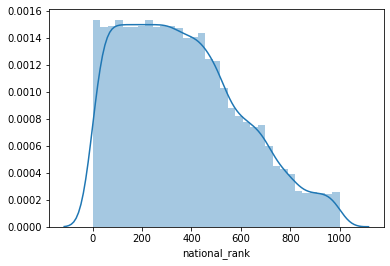

In [264]:
sns.distplot(test['national_rank'].astype(float))

Now we look at the score of the recruits and see that the group up around 0.75 to 0.85 and the elites at 0.95 to 1 

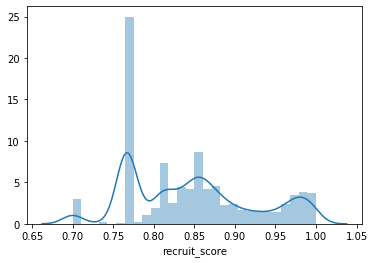

In [265]:
sns.distplot(test['recruit_score'].astype(float))